# Pre-processing

## Initializations

In [1]:
# Required packages
import pandas as pd       # For data handling
import numpy as np        # For numerical operations (optional but useful)
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns     # For nicer statistical plots
import scienceplots
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer # For transformations 
from sklearn.decomposition import PCA # For Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, leaves_list

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sys
import os

# Absolute path to the repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../"))

if repo_root not in sys.path:
    sys.path.append(repo_root)

from utils import check_transform_suitability, selective_transform, near_zero_var, find_correlation, plot_corr

# Set the plotting style
sns.set_theme(style="darkgrid")  # Set theme for seaborn plots

# Load data required for the analysis in this notebook
df = pd.read_parquet("../../data/segmentation.parquet")
cars = pd.read_parquet("../../data/cars.parquet")
glass = pd.read_parquet("../../data/glass.parquet")
soybean = pd.read_parquet("../../data/soybean.parquet")
bloodbrain = pd.read_parquet("../../data/bloodbrain.parquet")

## Investigate data

In [2]:
df.head()  # Quick peek at the data

Cell   Case Class    AngleCh1  AngleStatusCh1  AreaCh1  AreaStatusCh1  \
0  207827637   Test    PS  143.247705               1      185              0   
1  207932307  Train    PS  133.752037               0      819              1   
2  207932463  Train    WS  106.646387               0      431              0   
3  207932470  Train    PS   69.150325               0      298              0   
4  207932455   Test    PS    2.887837               2      285              0   

   AvgIntenCh1  AvgIntenCh2  AvgIntenCh3  ...  VarIntenCh1  VarIntenCh3  \
0    15.711864     3.954802     9.548023  ...    12.474676     7.609035   
1    31.923274   205.878517    69.916880  ...    18.809225    56.715352   
2    28.038835   115.315534    63.941748  ...    17.295643    37.671053   
3    19.456140   101.294737    28.217544  ...    13.818968    30.005643   
4    24.275735   111.415441    20.474265  ...    15.407972    20.504288   

   VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  VarIntenStatusCh4  \
0     2.714100                  0                  2                  2   
1   118.388139                  0                  0                  0   
2    49.470524                  0                  0                  0   
3    24.749537                  0                  0                  2   
4    45.450457                  0                  0                  0   

    WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
0  10.642974               2         42         14  
1  32.161261               1        215        347  
2  21.185525               0        371        252  
3  13.392830               0        487        295  
4  13.198561               0        283        159  

[5 rows x 119 columns]

In [3]:
print(df.describe())   # Summary statistics for numeric columns

               Cell     AngleCh1  AngleStatusCh1      AreaCh1  AreaStatusCh1  \
count  2.019000e+03  2019.000000     2019.000000  2019.000000    2019.000000   
mean   2.084024e+08    90.493405        0.568598   320.336305       0.080238   
std    2.790457e+05    48.760000        0.795568   214.023533       0.271728   
min    2.078276e+08     0.030876        0.000000   150.000000       0.000000   
25%    2.083325e+08    53.892207        0.000000   193.000000       0.000000   
50%    2.083843e+08    90.588773        0.000000   253.000000       0.000000   
75%    2.084052e+08   126.682013        1.000000   362.500000       0.000000   
max    2.109641e+08   179.939323        2.000000  2186.000000       1.000000   

       AvgIntenCh1  AvgIntenCh2  AvgIntenCh3  AvgIntenCh4  AvgIntenStatusCh1  \
count  2019.000000  2019.000000  2019.000000  2019.000000        2019.000000   
mean    126.071679   188.052115    96.420171   140.701586           0.196137   
std     165.008380   158.956105    96.6

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Columns: 119 entries, Cell to YCentroid
dtypes: category(2), float64(49), int32(68)
memory usage: 1.3 MB


In [5]:
list(df.columns) # List of all columns in the DataFrame


['Cell',
 'Case',
 'Class',
 'AngleCh1',
 'AngleStatusCh1',
 'AreaCh1',
 'AreaStatusCh1',
 'AvgIntenCh1',
 'AvgIntenCh2',
 'AvgIntenCh3',
 'AvgIntenCh4',
 'AvgIntenStatusCh1',
 'AvgIntenStatusCh2',
 'AvgIntenStatusCh3',
 'AvgIntenStatusCh4',
 'ConvexHullAreaRatioCh1',
 'ConvexHullAreaRatioStatusCh1',
 'ConvexHullPerimRatioCh1',
 'ConvexHullPerimRatioStatusCh1',
 'DiffIntenDensityCh1',
 'DiffIntenDensityCh3',
 'DiffIntenDensityCh4',
 'DiffIntenDensityStatusCh1',
 'DiffIntenDensityStatusCh3',
 'DiffIntenDensityStatusCh4',
 'EntropyIntenCh1',
 'EntropyIntenCh3',
 'EntropyIntenCh4',
 'EntropyIntenStatusCh1',
 'EntropyIntenStatusCh3',
 'EntropyIntenStatusCh4',
 'EqCircDiamCh1',
 'EqCircDiamStatusCh1',
 'EqEllipseLWRCh1',
 'EqEllipseLWRStatusCh1',
 'EqEllipseOblateVolCh1',
 'EqEllipseOblateVolStatusCh1',
 'EqEllipseProlateVolCh1',
 'EqEllipseProlateVolStatusCh1',
 'EqSphereAreaCh1',
 'EqSphereAreaStatusCh1',
 'EqSphereVolCh1',
 'EqSphereVolStatusCh1',
 'FiberAlign2Ch3',
 'FiberAlign2Ch4',
 '

In [6]:
# Extract the training subset indicated by the "Case" column
train_df = df[df["Case"] == "Train"]
train_df.head()  # Preview the subset

Cell   Case Class    AngleCh1  AngleStatusCh1  AreaCh1  \
1   207932307  Train    PS  133.752037               0      819   
2   207932463  Train    WS  106.646387               0      431   
3   207932470  Train    PS   69.150325               0      298   
11  207932484  Train    WS  109.416426               0      256   
14  207932459  Train    PS  104.278654               0      258   

    AreaStatusCh1  AvgIntenCh1  AvgIntenCh2  AvgIntenCh3  ...  VarIntenCh1  \
1               1    31.923274   205.878517    69.916880  ...    18.809225   
2               0    28.038835   115.315534    63.941748  ...    17.295643   
3               0    19.456140   101.294737    28.217544  ...    13.818968   
11              0    18.828571   125.938776    13.600000  ...    13.922937   
14              0    17.570850   124.368421    22.461538  ...    12.324971   

    VarIntenCh3  VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  \
1     56.715352   118.388139                  0                  0   
2     37.671053    49.470524                  0                  0   
3     30.005643    24.749537                  0                  0   
11    18.643027    40.331747                  0                  0   
14    17.747143    41.928533                  0                  0   

    VarIntenStatusCh4   WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
1                   0  32.161261               1        215        347  
2                   0  21.185525               0        371        252  
3                   2  13.392830               0        487        295  
11                  2  17.546861               0        211        495  
14                  2  17.660339               0        172        207  

[5 rows x 119 columns]

In [7]:
train_df.shape # Check number of training samples

(1009, 119)

In [8]:
# Assign the first 3 columns to new variables
# These columns are assumed to be "Cell", "Class", and "Case"
cellID = train_df["Cell"]
case = train_df["Case"]
class_ = train_df["Class"]
# Drop the specified columns
train_df = train_df.drop(["Cell", "Class", "Case"], axis=1)

In [9]:
train_df.head()  # Preview the modified DataFrame

AngleCh1  AngleStatusCh1  AreaCh1  AreaStatusCh1  AvgIntenCh1  \
1   133.752037               0      819              1    31.923274   
2   106.646387               0      431              0    28.038835   
3    69.150325               0      298              0    19.456140   
11  109.416426               0      256              0    18.828571   
14  104.278654               0      258              0    17.570850   

    AvgIntenCh2  AvgIntenCh3  AvgIntenCh4  AvgIntenStatusCh1  \
1    205.878517    69.916880   164.153453                  0   
2    115.315534    63.941748   106.696602                  0   
3    101.294737    28.217544    31.028070                  0   
11   125.938776    13.600000    46.800000                  0   
14   124.368421    22.461538    71.206478                  0   

    AvgIntenStatusCh2  ...  VarIntenCh1  VarIntenCh3  VarIntenCh4  \
1                   0  ...    18.809225    56.715352   118.388139   
2                   0  ...    17.295643    37.671053    49.470524   
3                   0  ...    13.818968    30.005643    24.749537   
11                  0  ...    13.922937    18.643027    40.331747   
14                  0  ...    12.324971    17.747143    41.928533   

    VarIntenStatusCh1  VarIntenStatusCh3  VarIntenStatusCh4   WidthCh1  \
1                   0                  0                  0  32.161261   
2                   0                  0                  0  21.185525   
3                   0                  0                  2  13.392830   
11                  0                  0                  2  17.546861   
14                  0                  0                  2  17.660339   

    WidthStatusCh1  XCentroid  YCentroid  
1                1        215        347  
2                0        371        252  
3                0        487        295  
11               0        211        495  
14               0        172        207  

[5 rows x 116 columns]

## Transformations

### Skewness

In [10]:
# Calculate the skewness of the 'VarIntenCh3' as example
skew_value = skew(train_df['VarIntenCh3'], bias=True) # bias=True means that bias correction is off - Fine with large datasets
print(skew_value)

2.3951841812380814


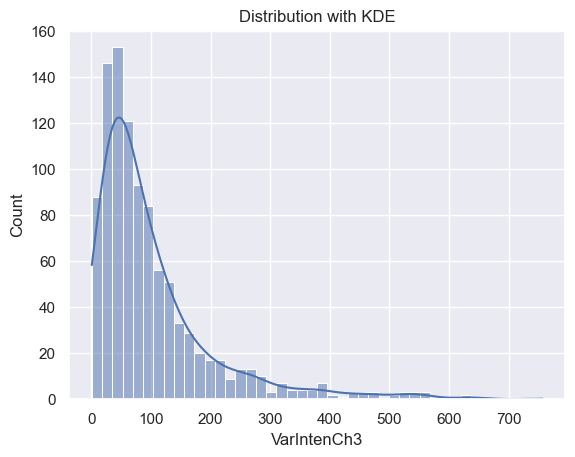

In [11]:
# Visualize the distribution of 'VarIntenCh3' using a histogram
sns.histplot(train_df['VarIntenCh3'], kde=True)
plt.title("Distribution with KDE")
plt.show()

In [12]:
# The original data contains "status" columns that are binary versions of the predictors.
# We remove these before applying the transformation functions defined above.
train_df = train_df[[col for col in train_df.columns if "Status" not in col]]

# Apply transformation suitability check
summary_df, boxcox_cols, yeojohnson_cols = check_transform_suitability(train_df, save_csv=True)
summary_df.head()  # Preview the summary DataFrame

Summary saved to transform_suitability.csv


Column Data Type  Skewness  Apply Transformation  Box-Cox Applicable  \
0     AngleCh1   float64 -0.024299                 False                True   
1      AreaCh1     int32  3.530354                  True                True   
2  AvgIntenCh1   float64  2.963590                  True                True   
3  AvgIntenCh2   float64  0.849423                  True               False   
4  AvgIntenCh3   float64  2.205620                  True                True   

   Yeo-Johnson Applicable  NaN Count  NaN %  
0                    True          0  0.00%  
1                    True          0  0.00%  
2                    True          0  0.00%  
3                    True          0  0.00%  
4                    True          0  0.00%

In [13]:
# Apply selective transformation based on the summary DataFrame
train_df_trans = selective_transform(train_df, summary_df) 
# There is a difference in transformed values when comparing to the book. 
# This is because the book does not apply centering and scaling to the columns that 
# are not transformed right away. To get the same results, use argument 'standardize=False' 
# in the PowerTransformer constructor. There will still be a slight discrepancy which 
# appears to be because the R box-cox function makes a rougher estimate of lambda 
# (-0.9 vs -0.-0.85586872).

### Create plots to visualize transformations

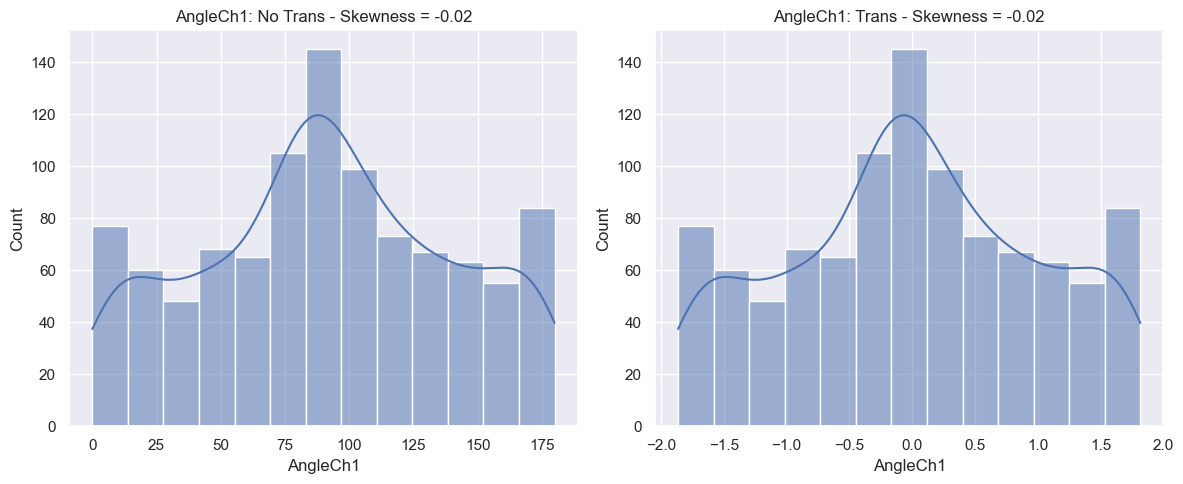

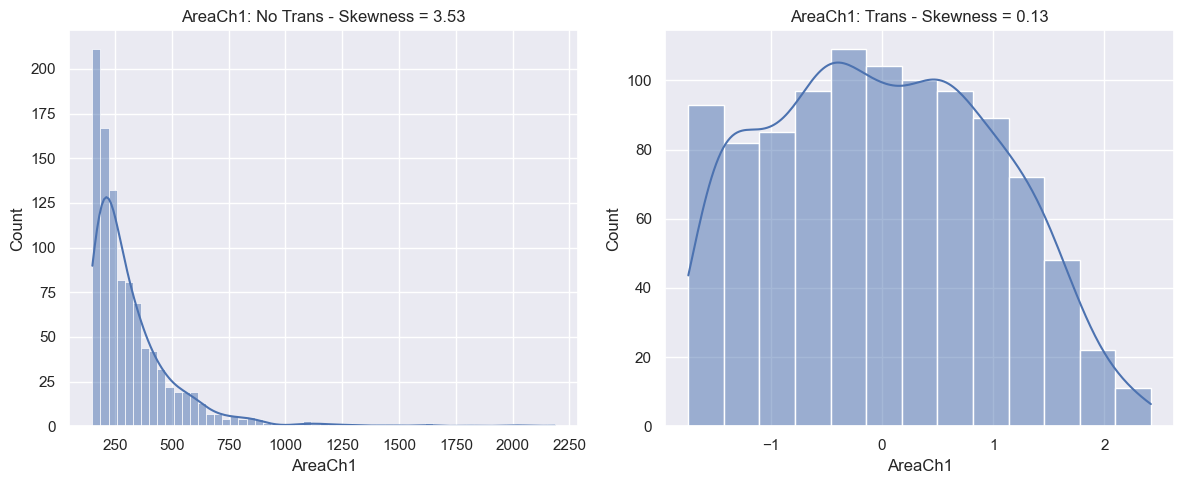

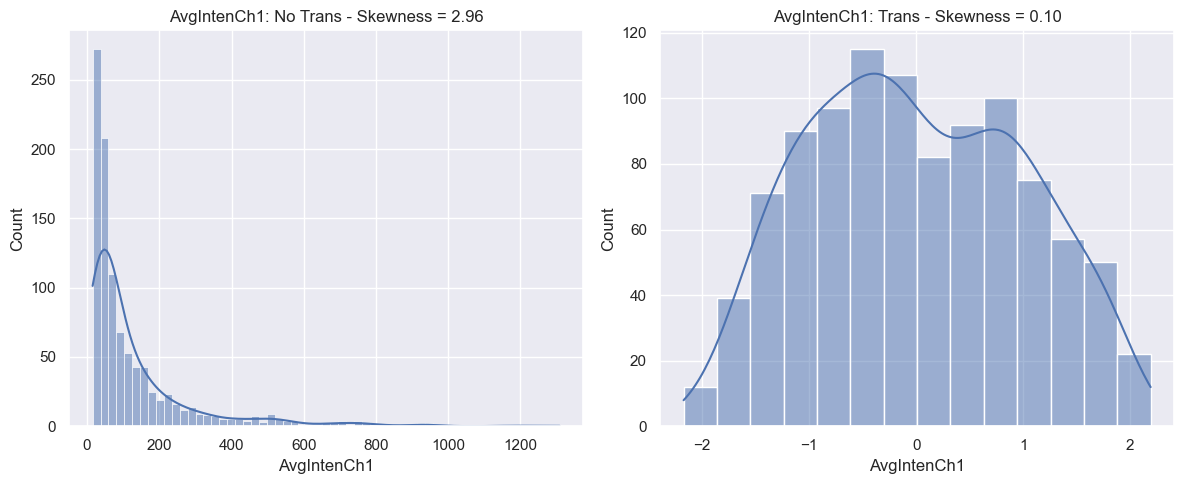

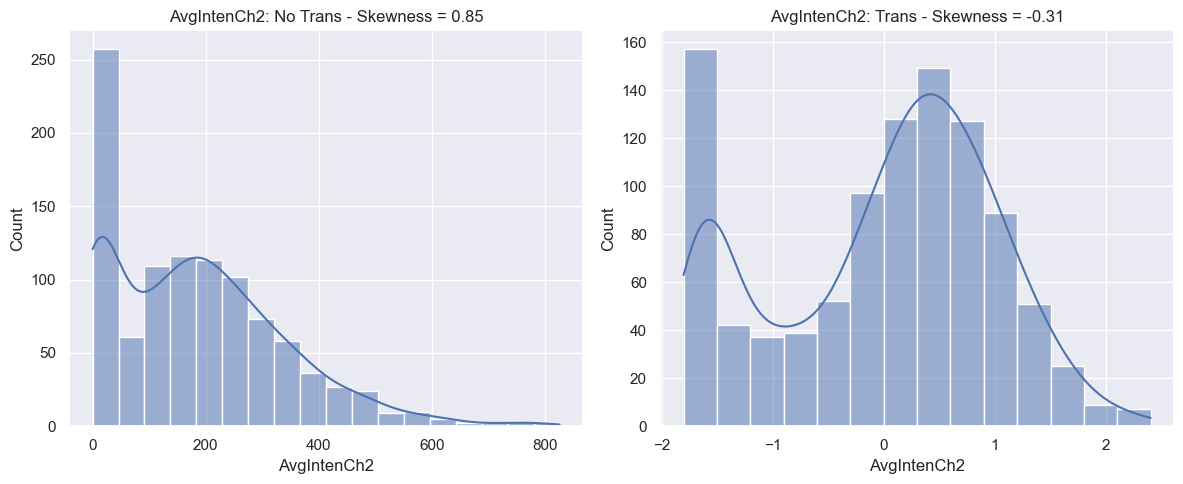

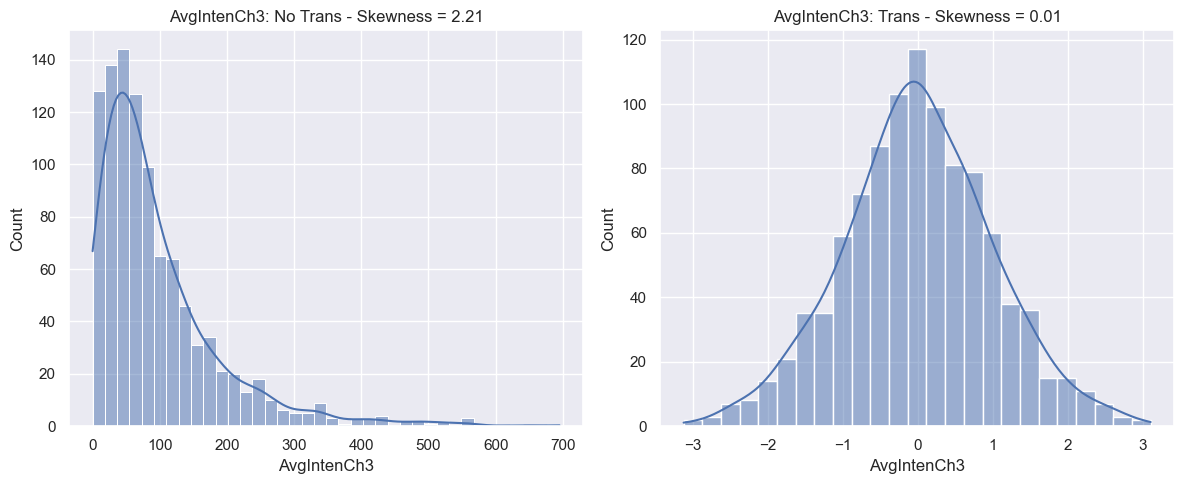

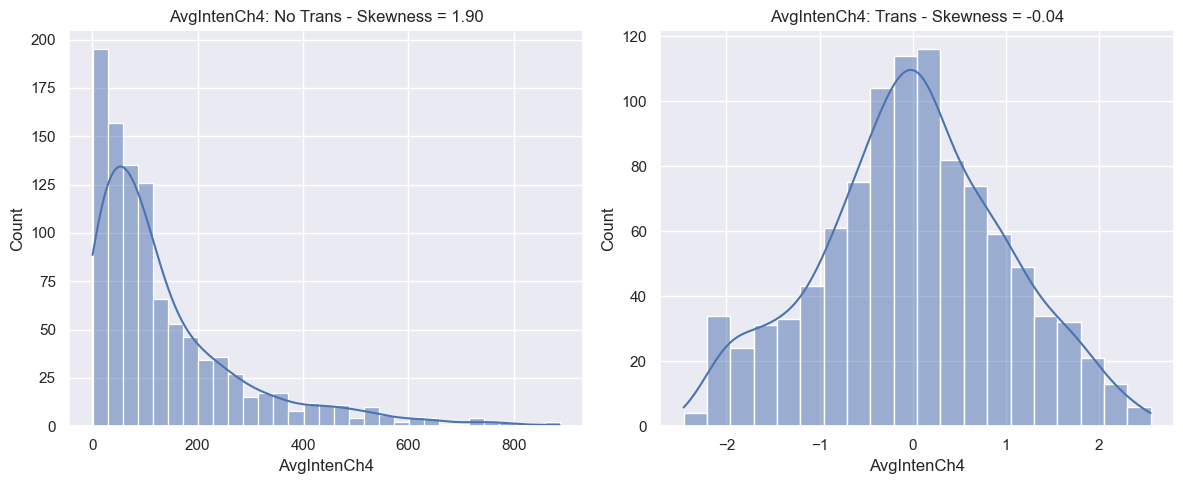

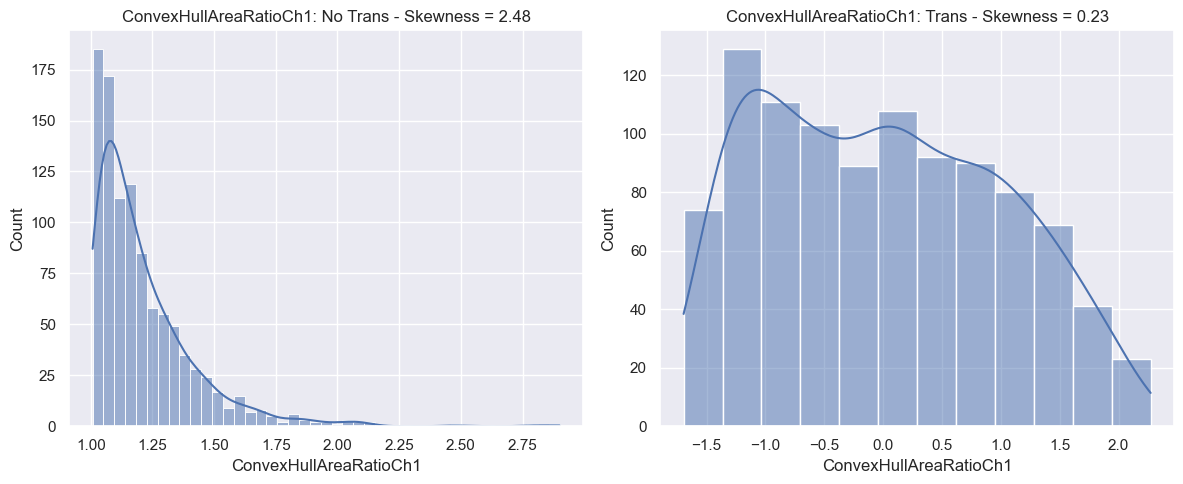

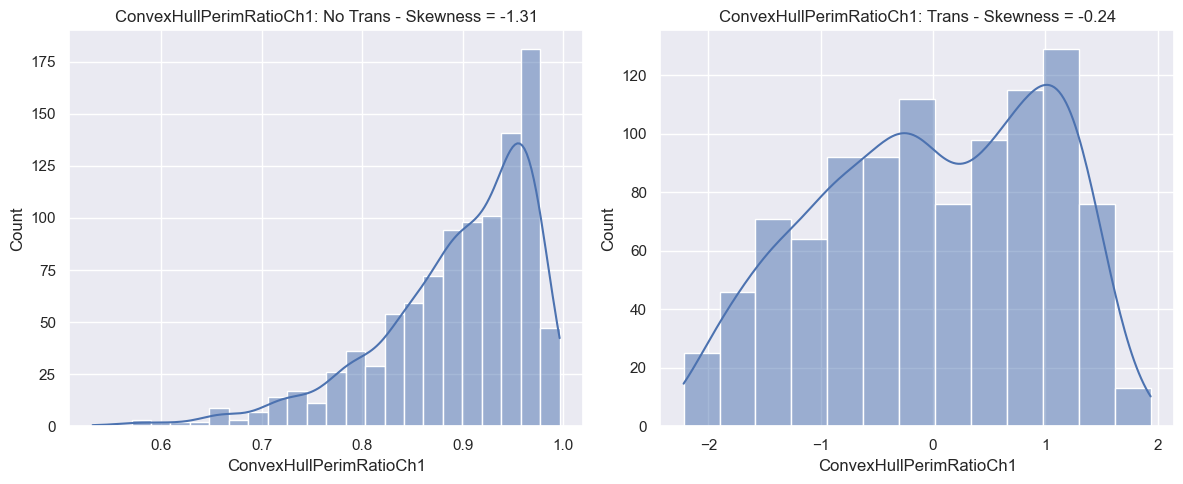

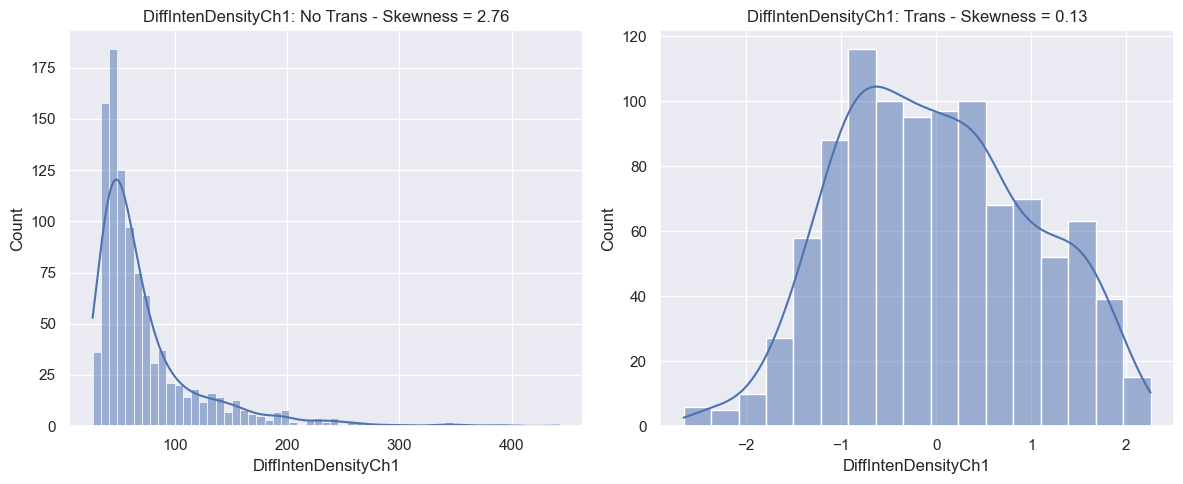

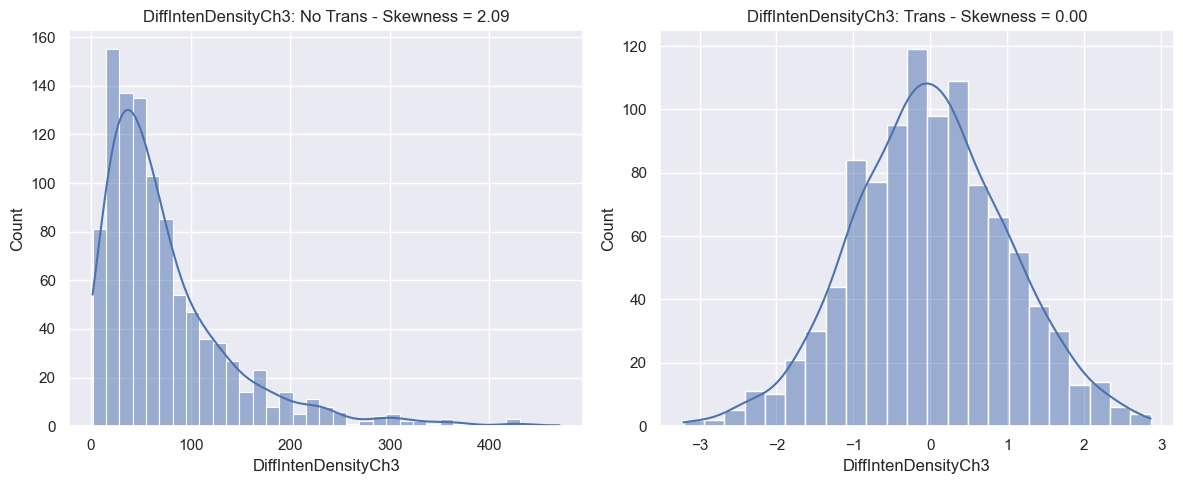

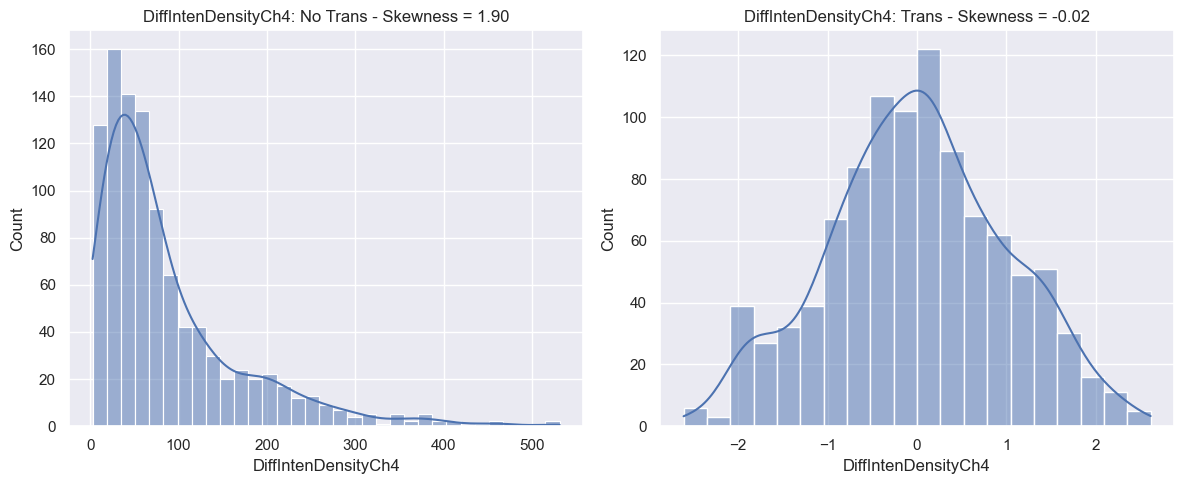

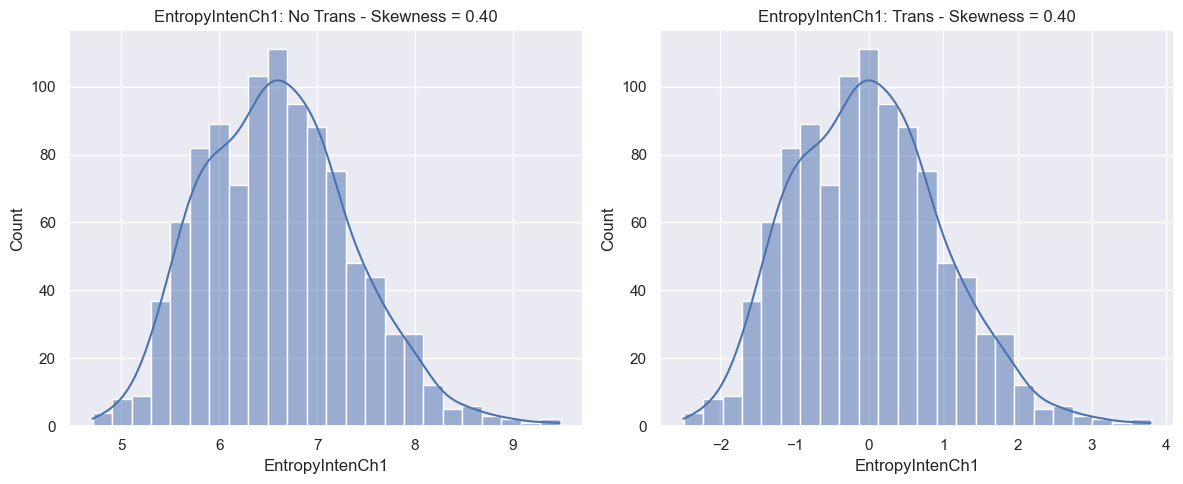

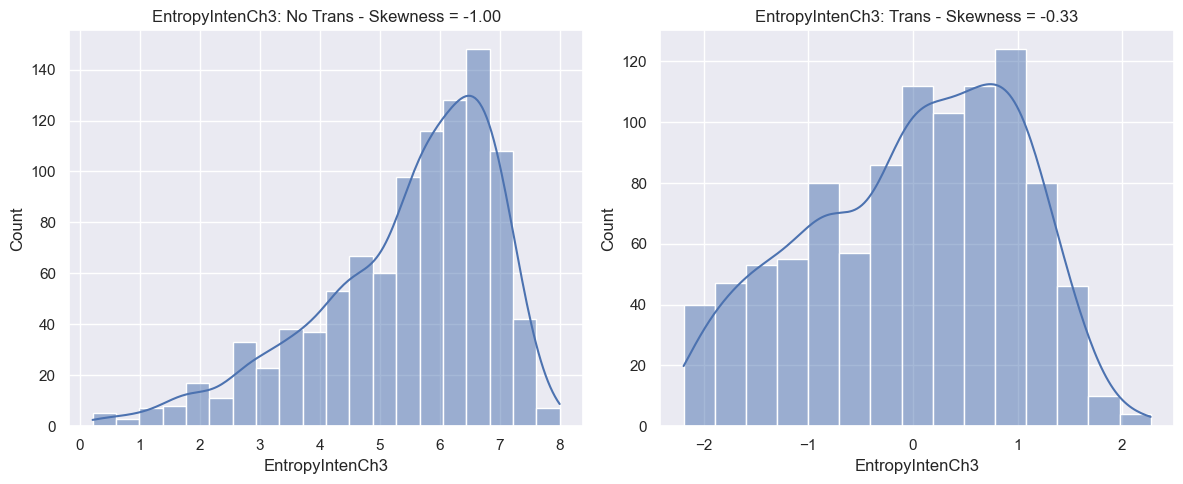

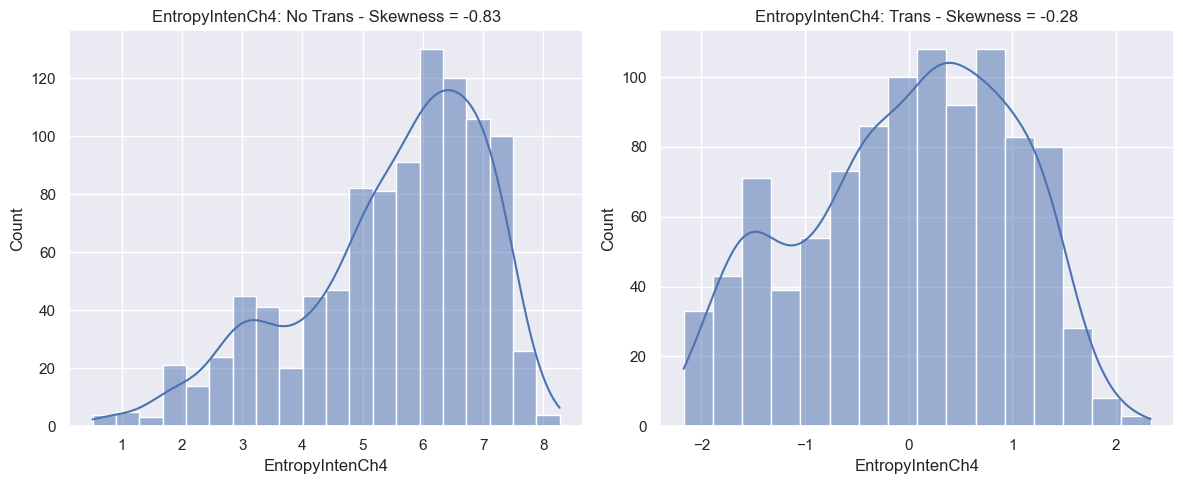

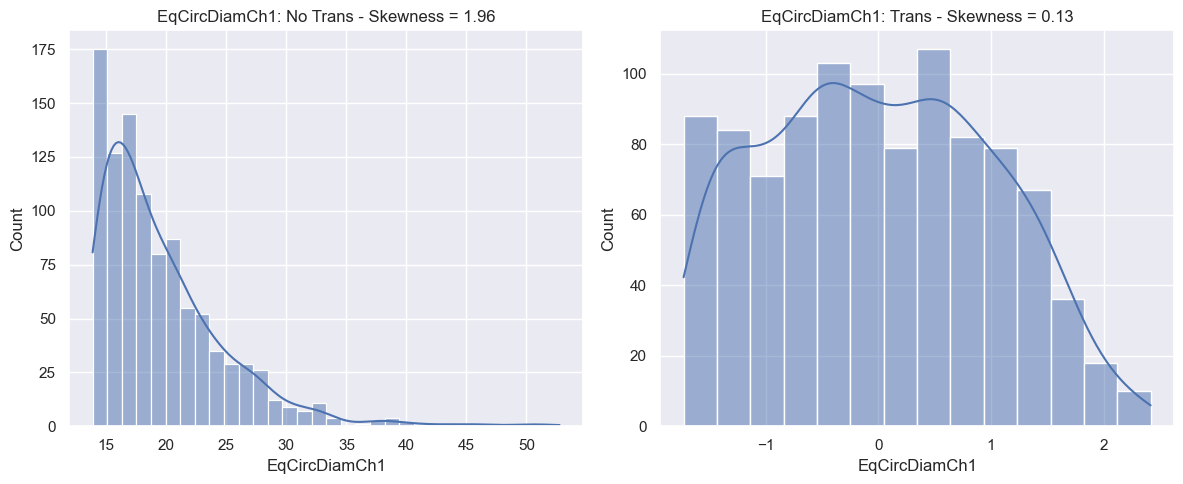

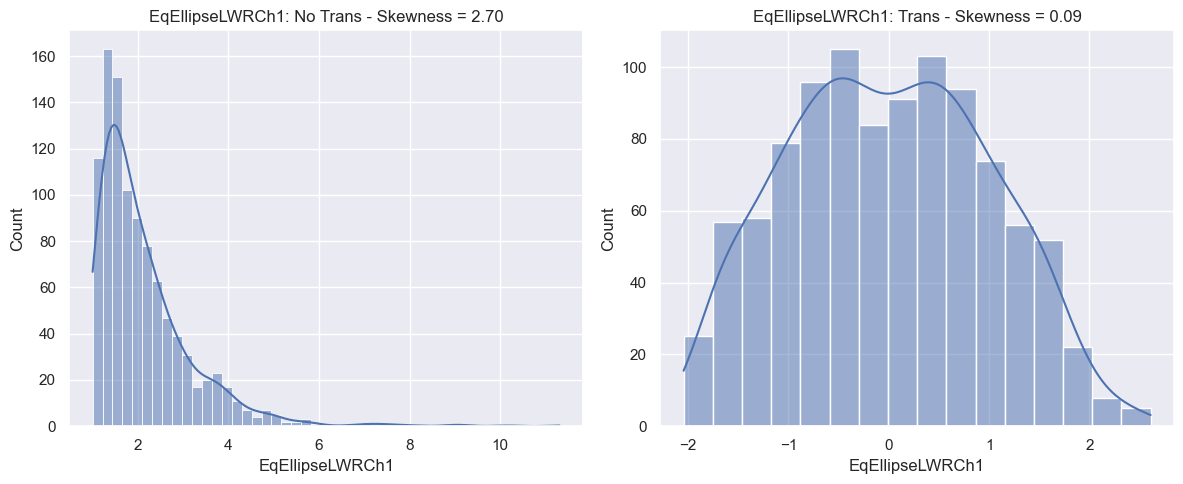

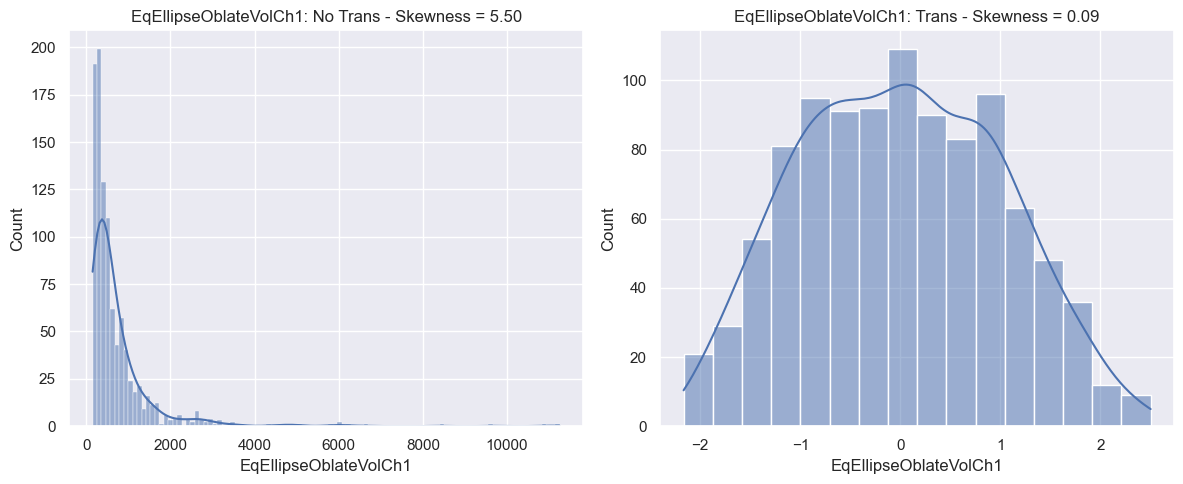

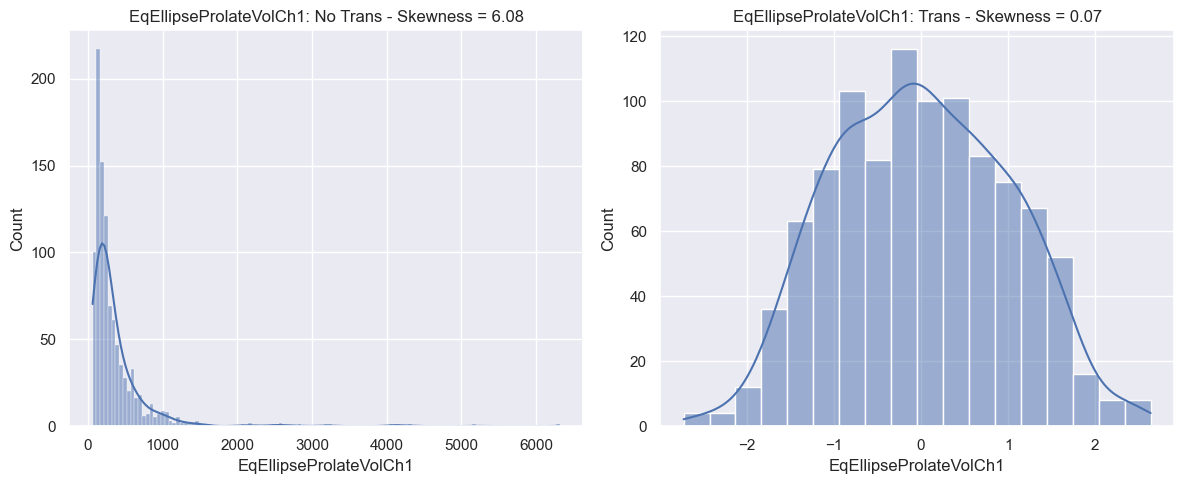

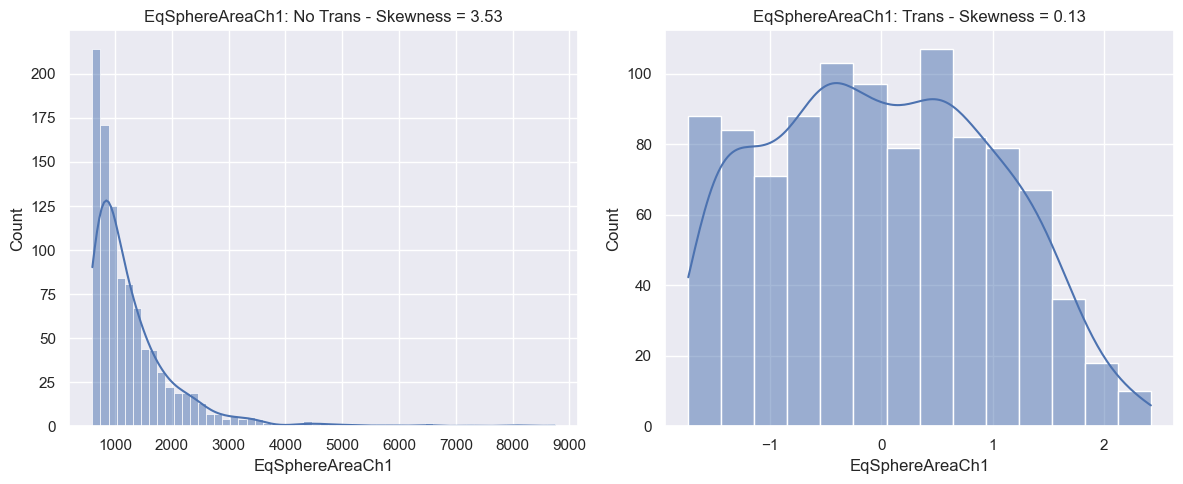

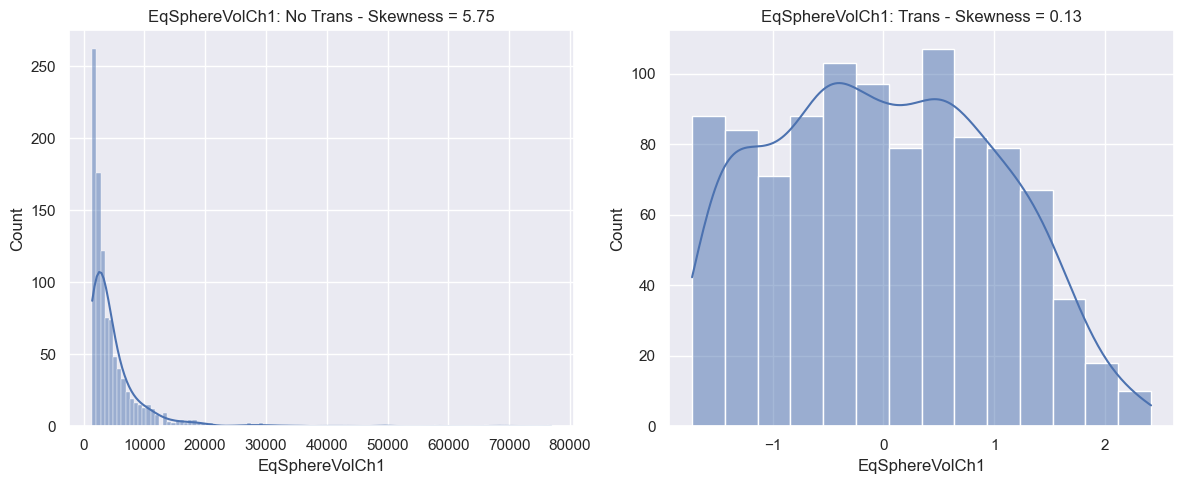

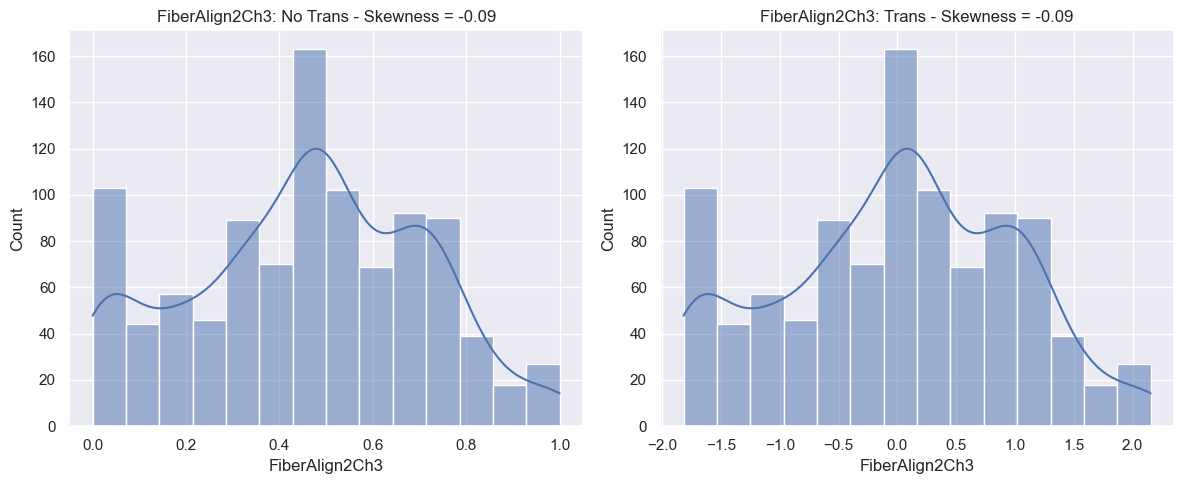

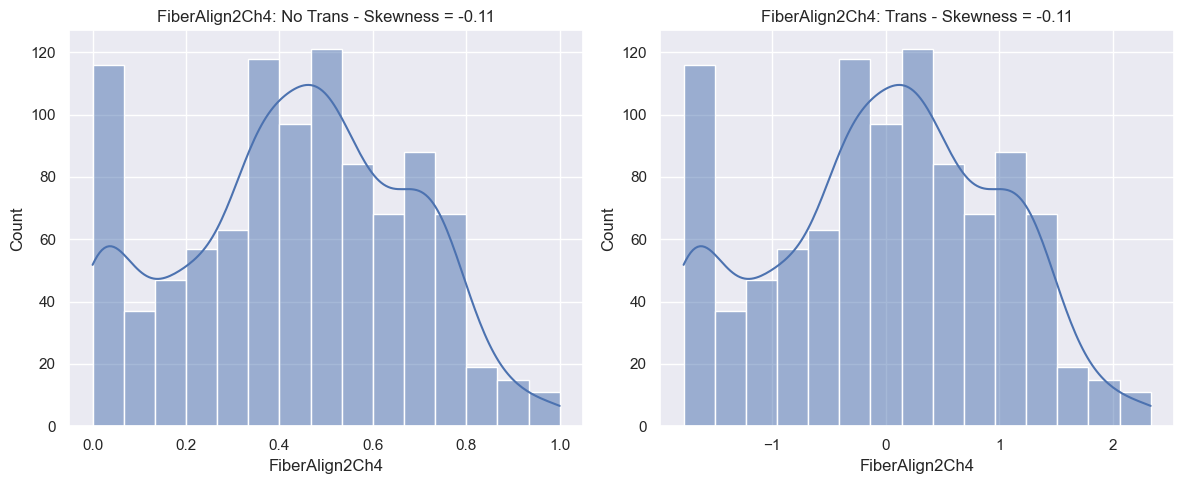

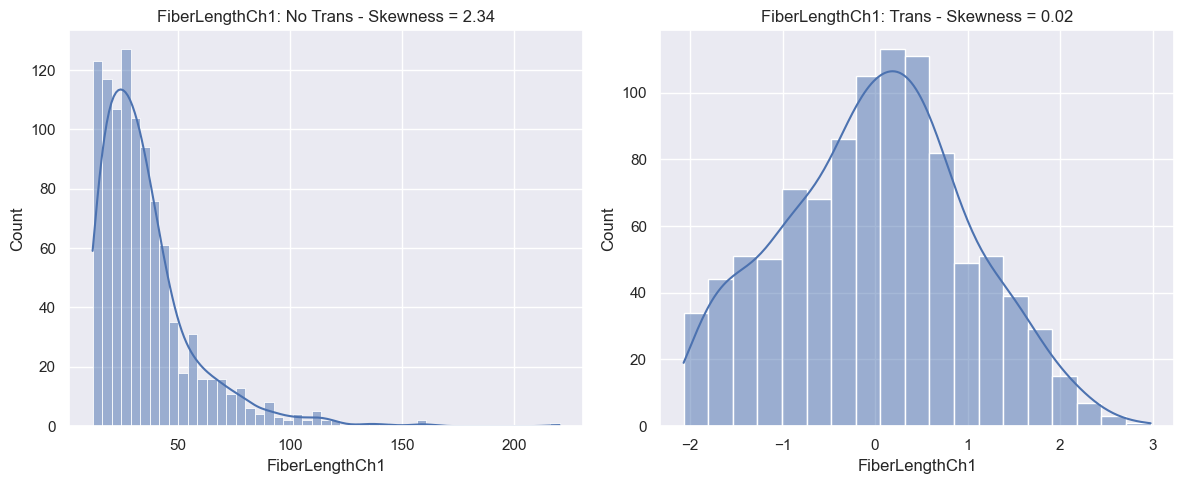

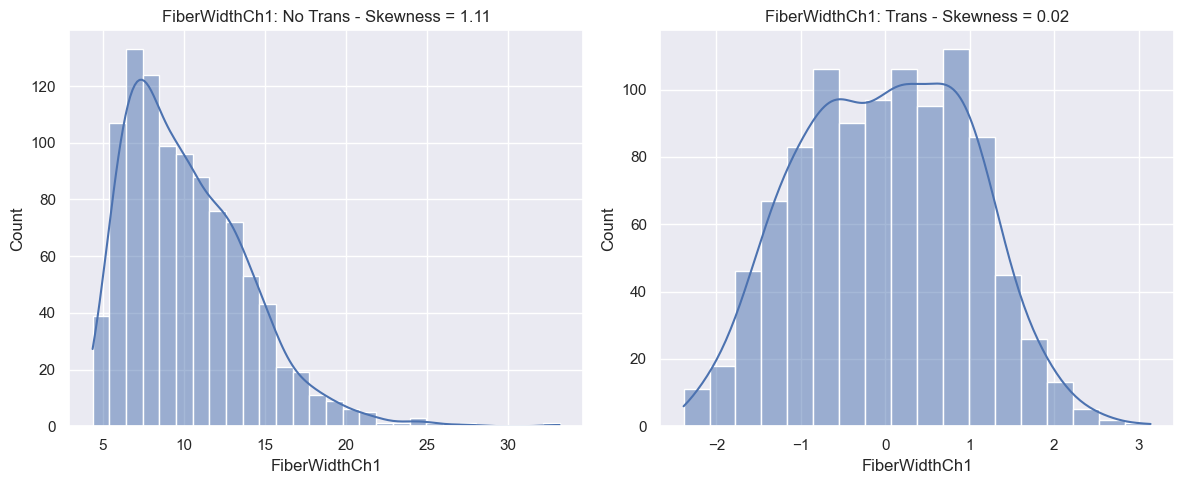

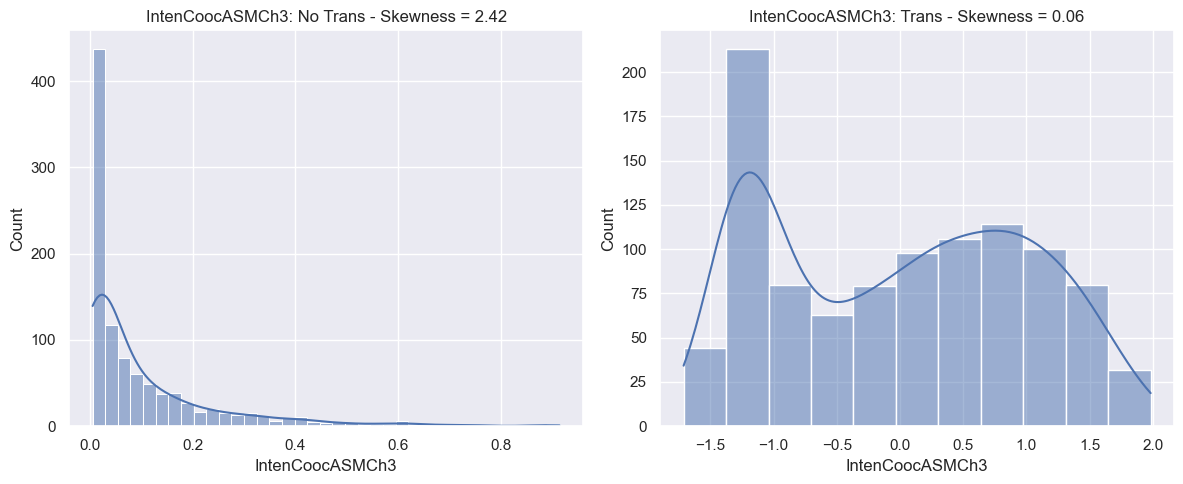

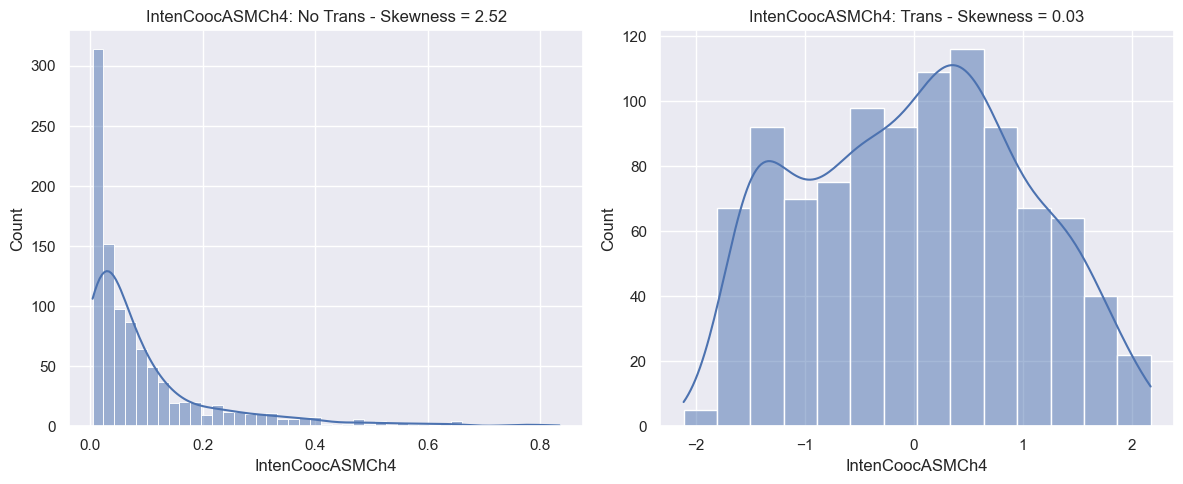

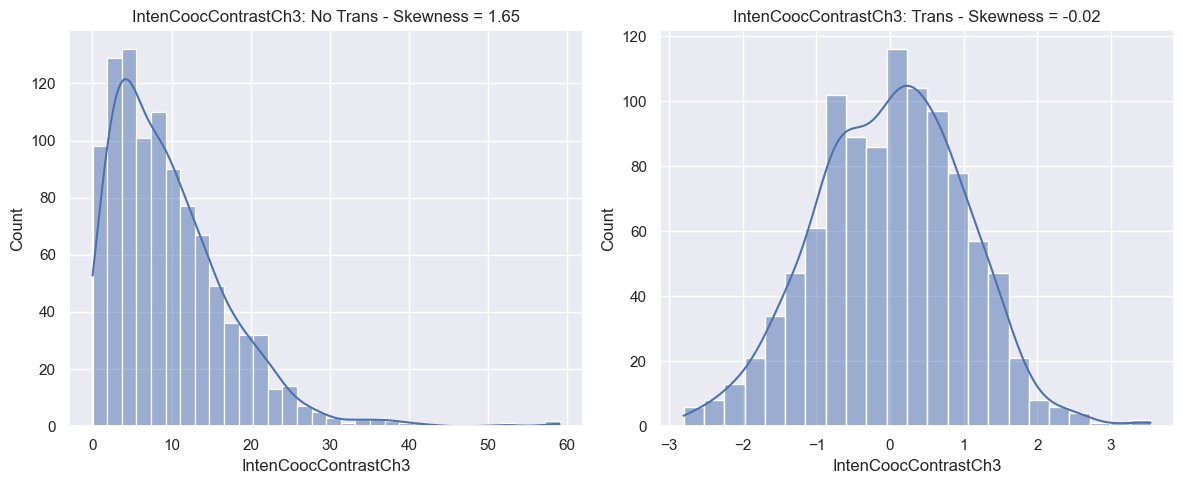

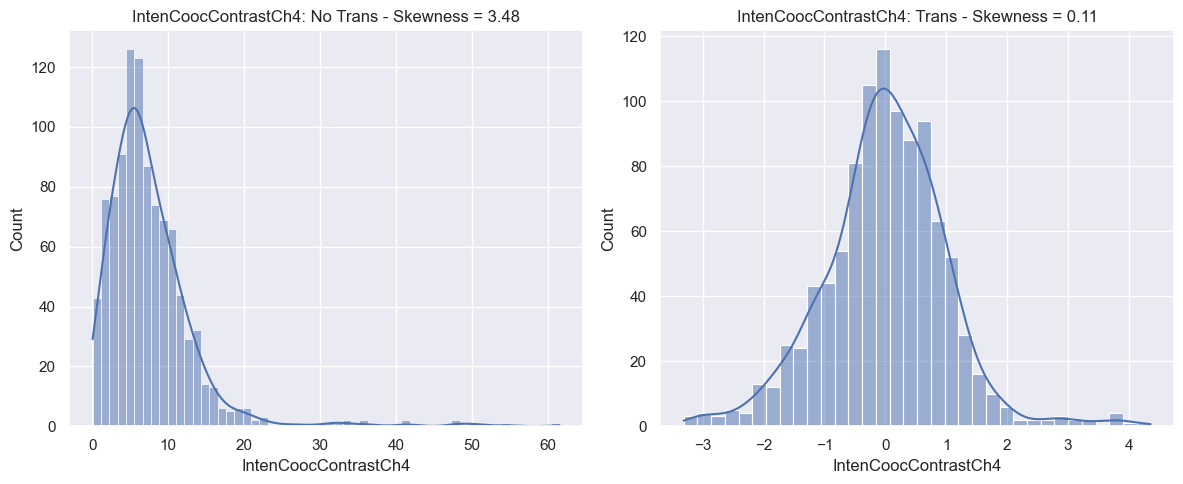

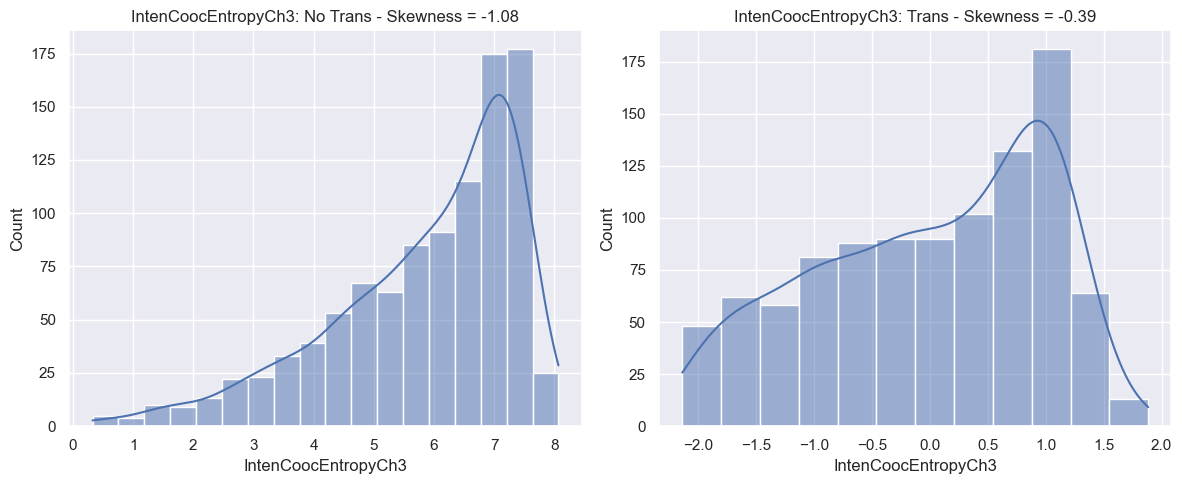

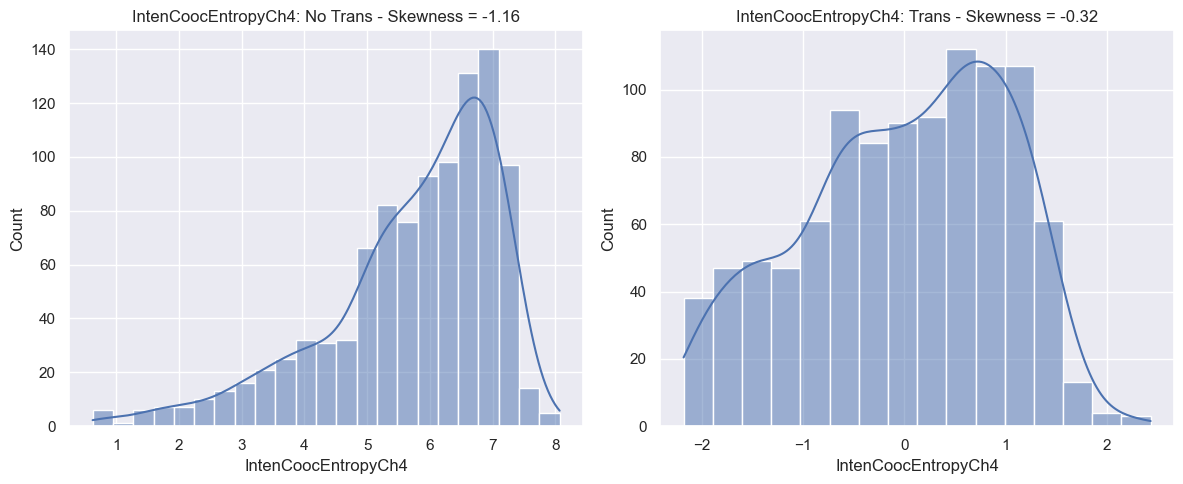

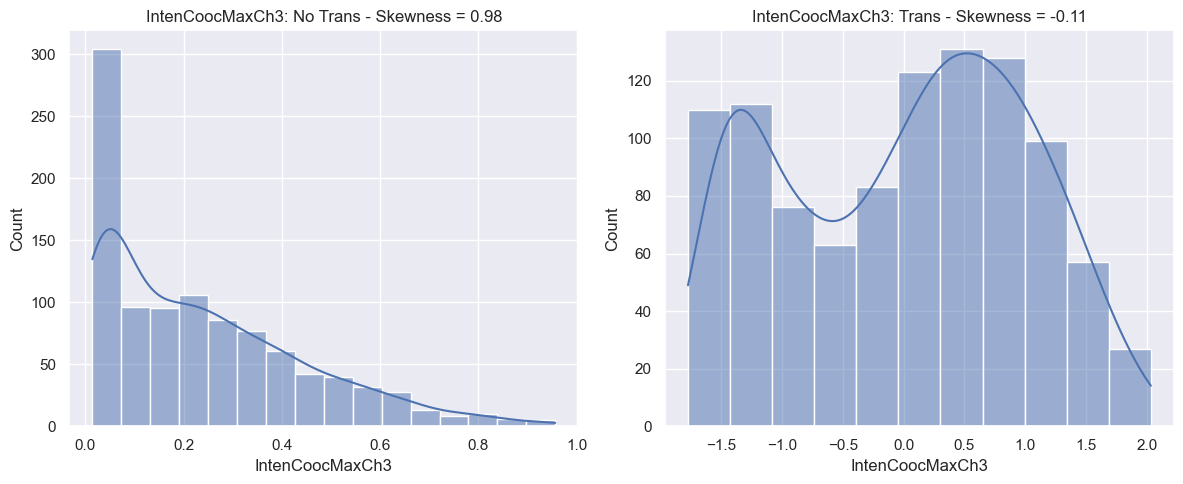

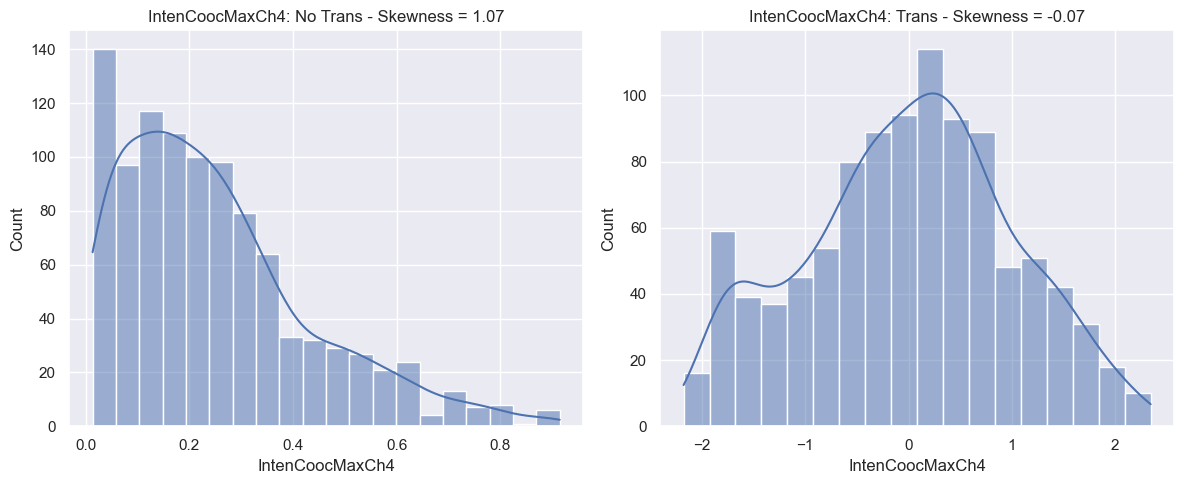

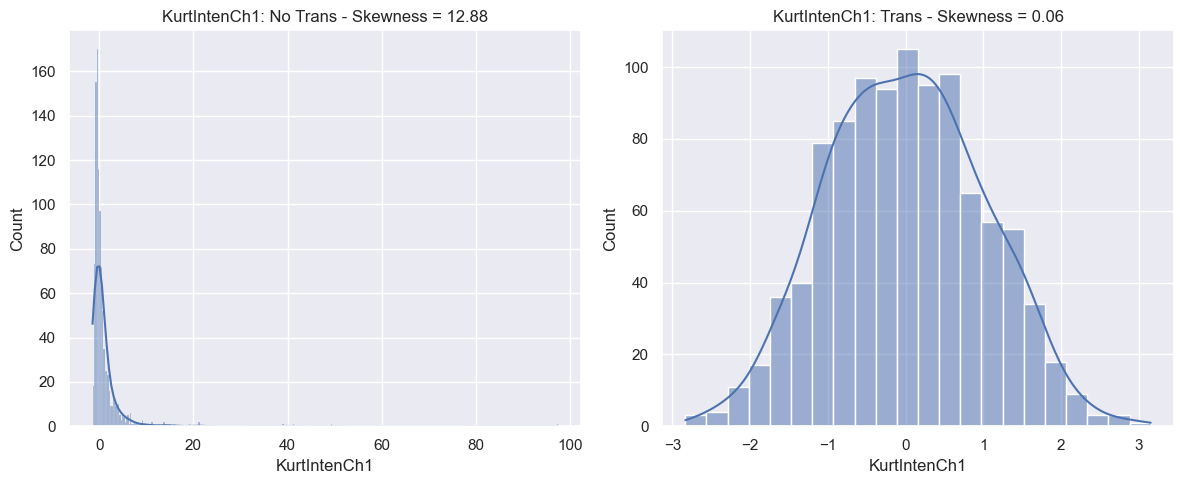

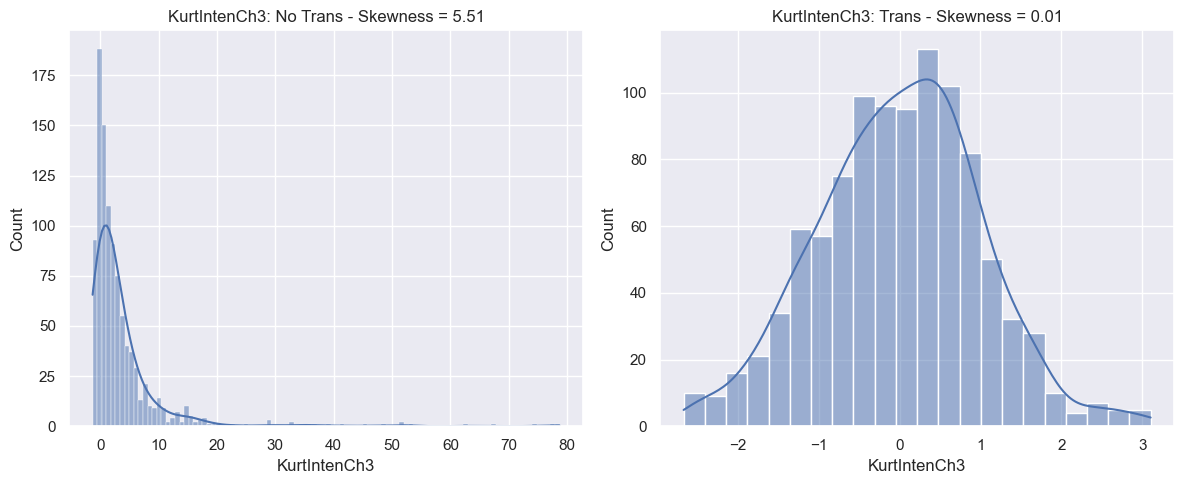

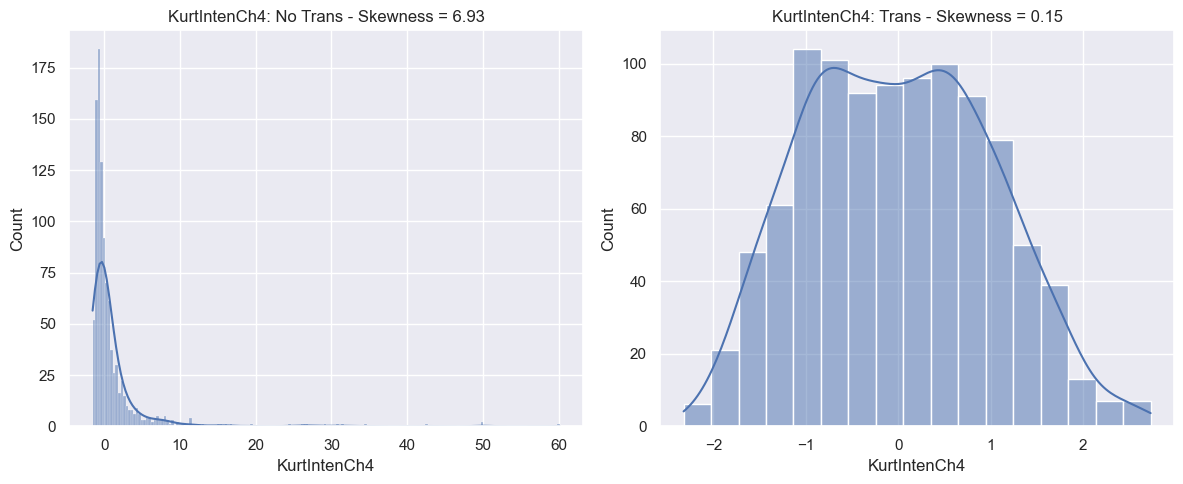

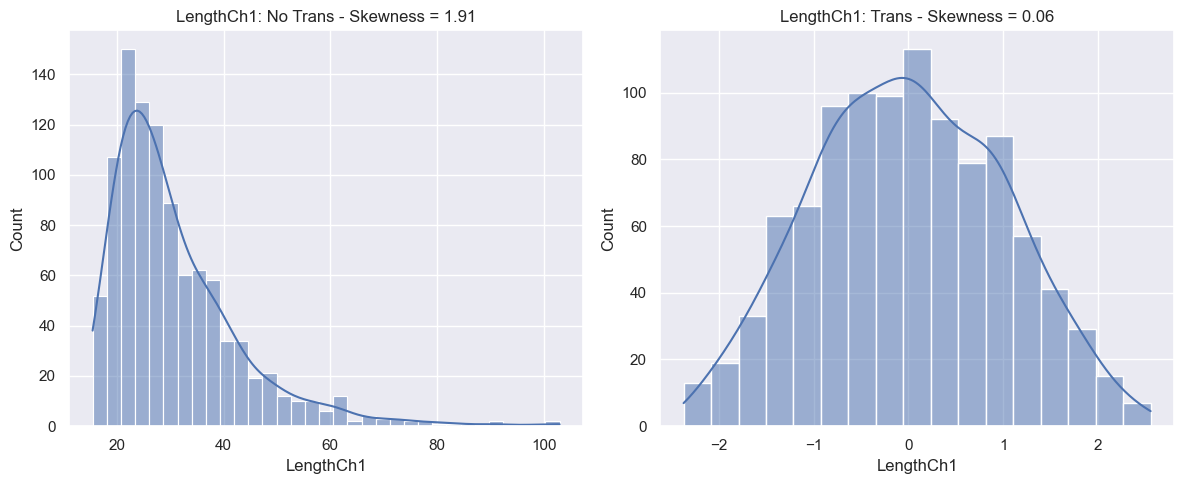

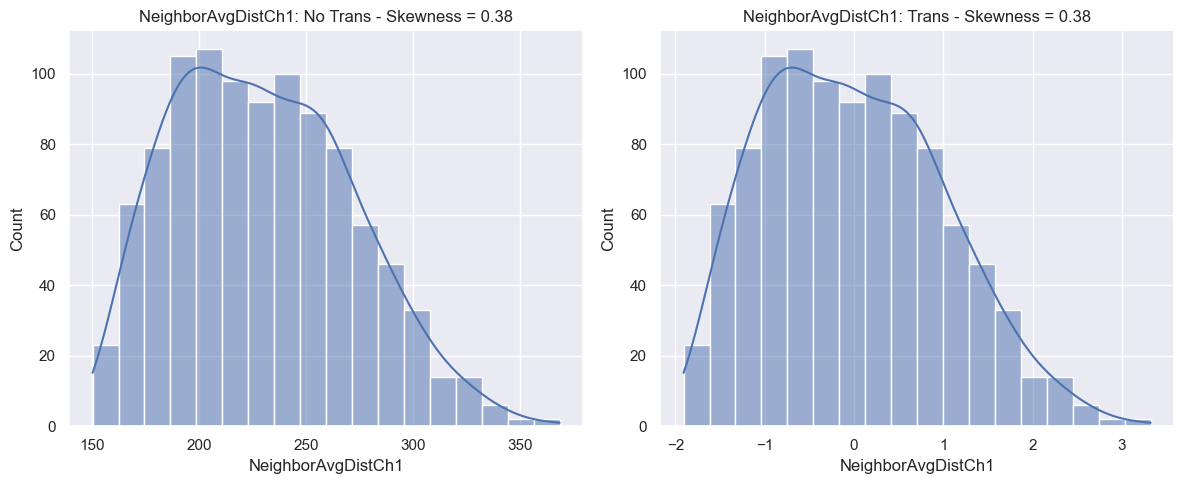

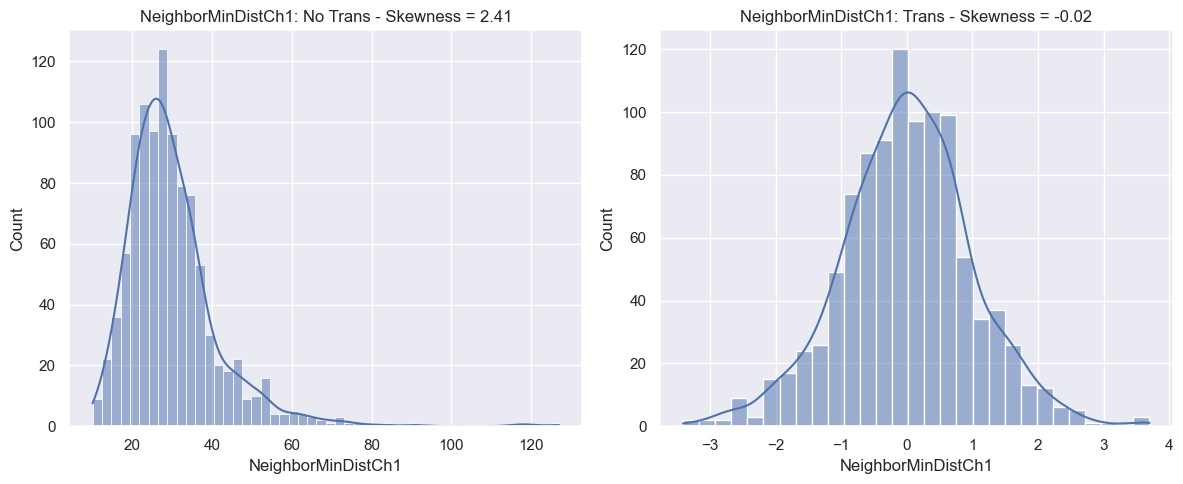

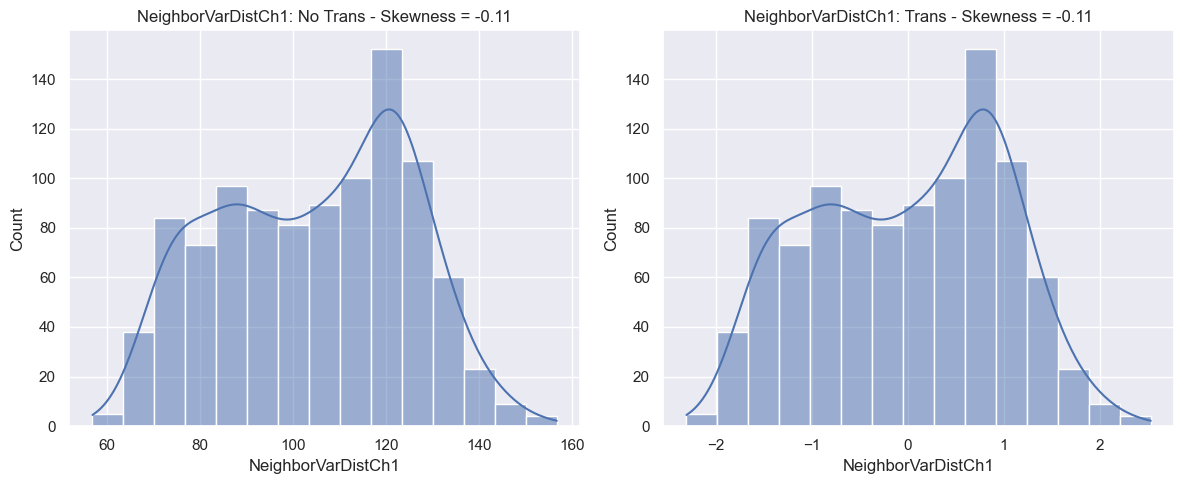

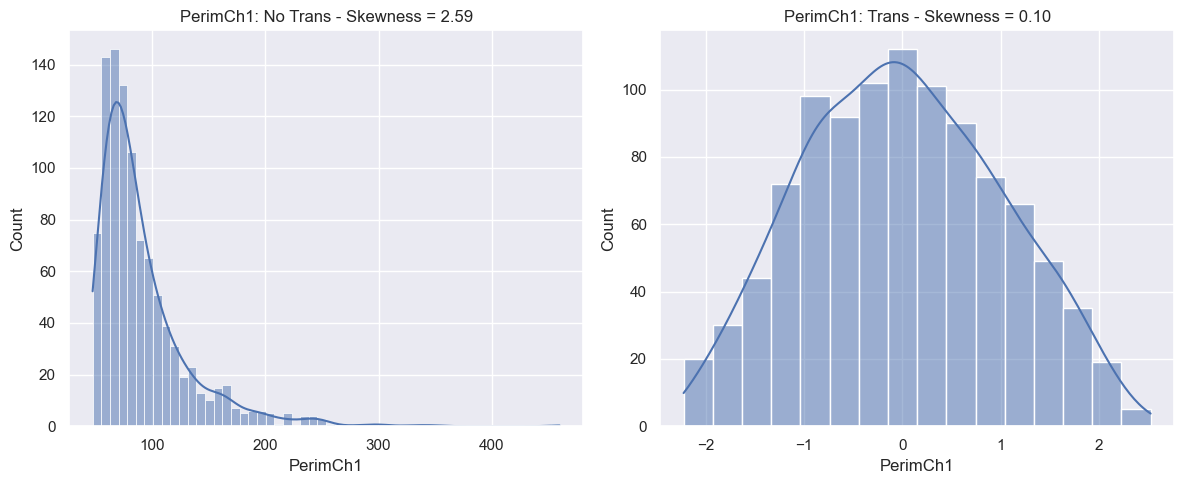

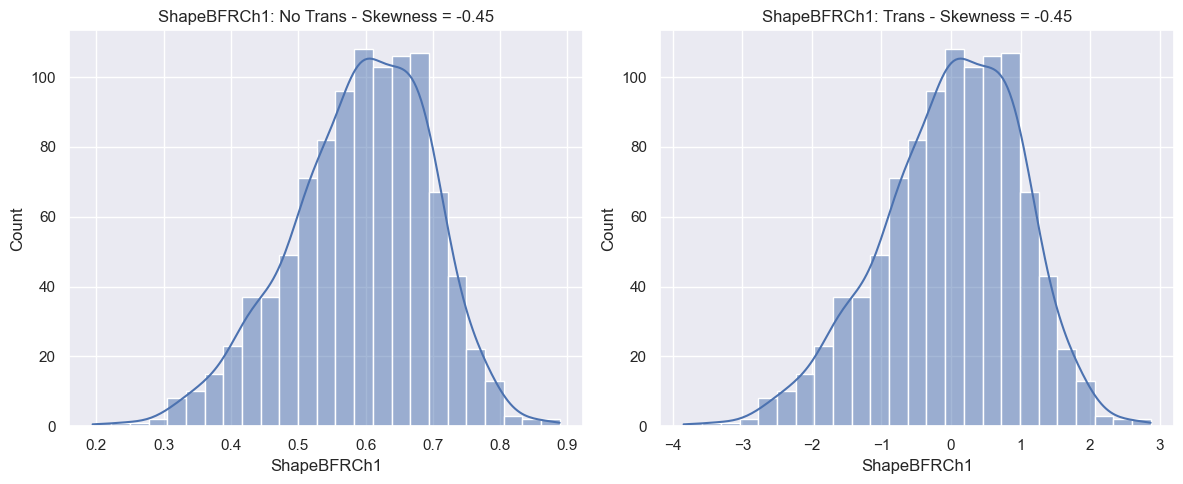

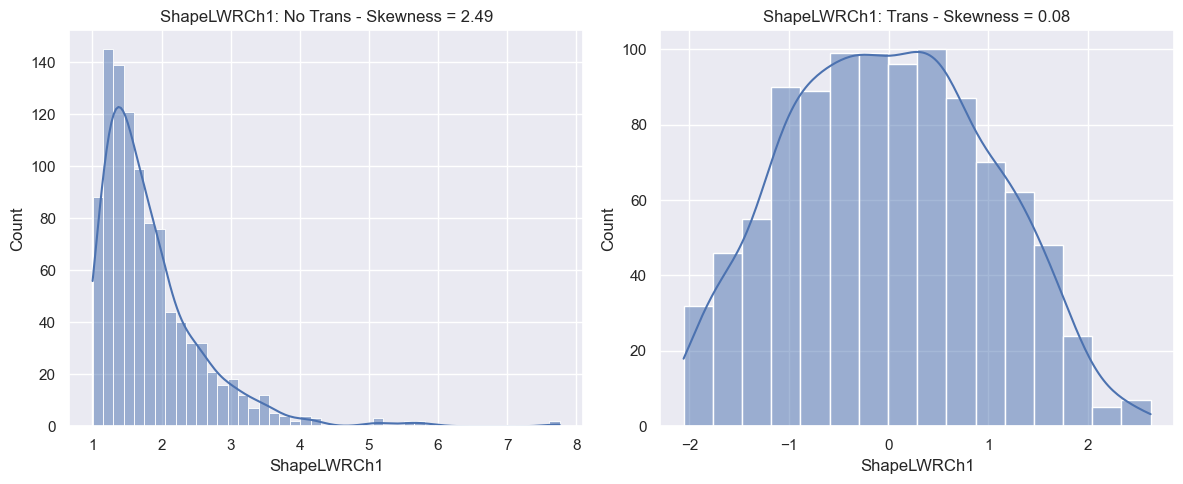

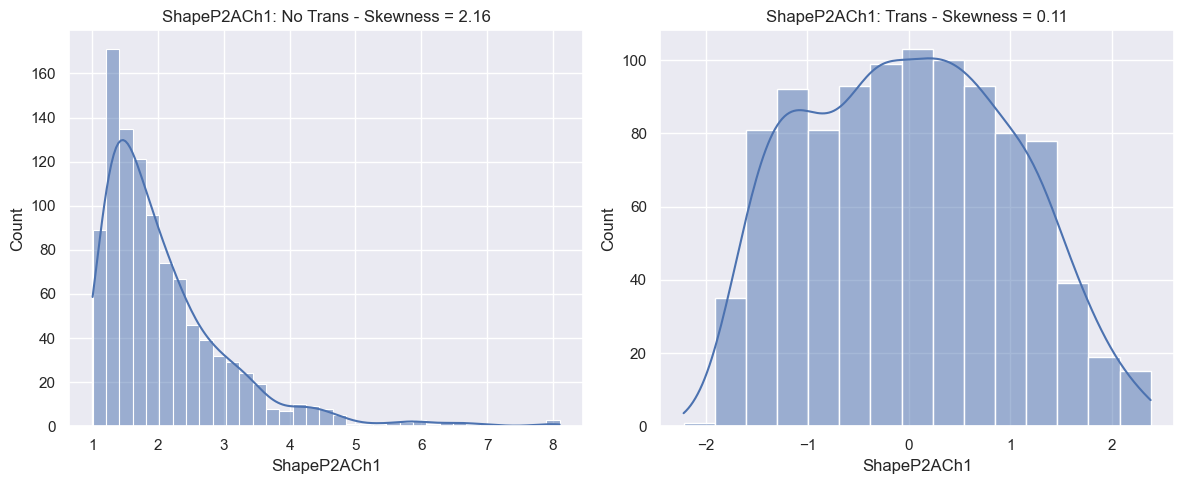

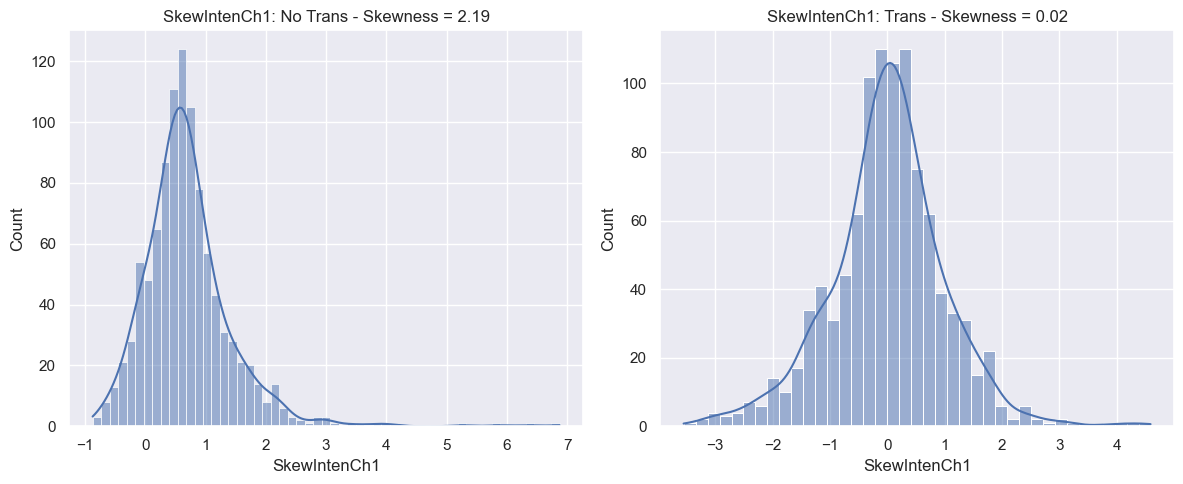

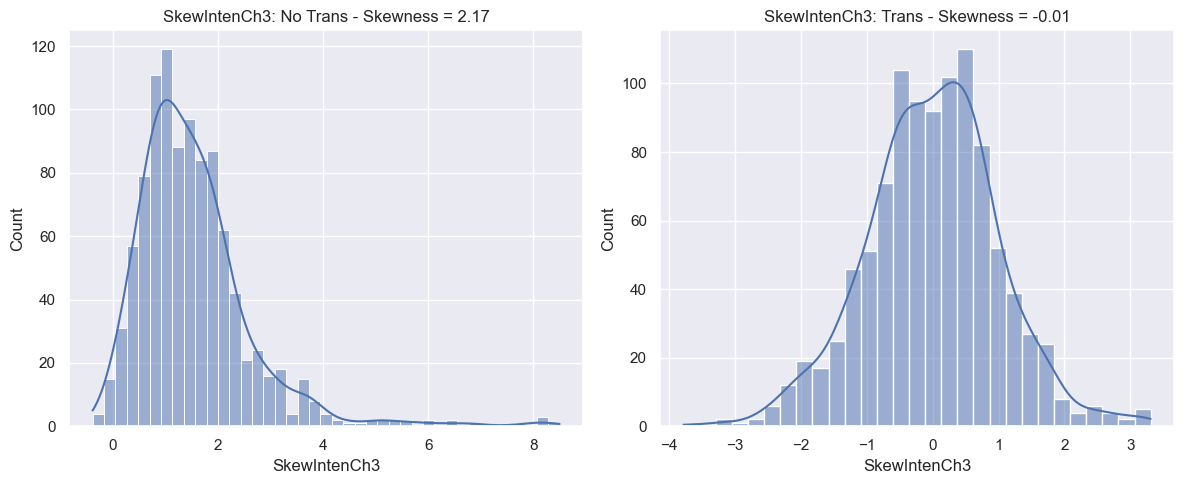

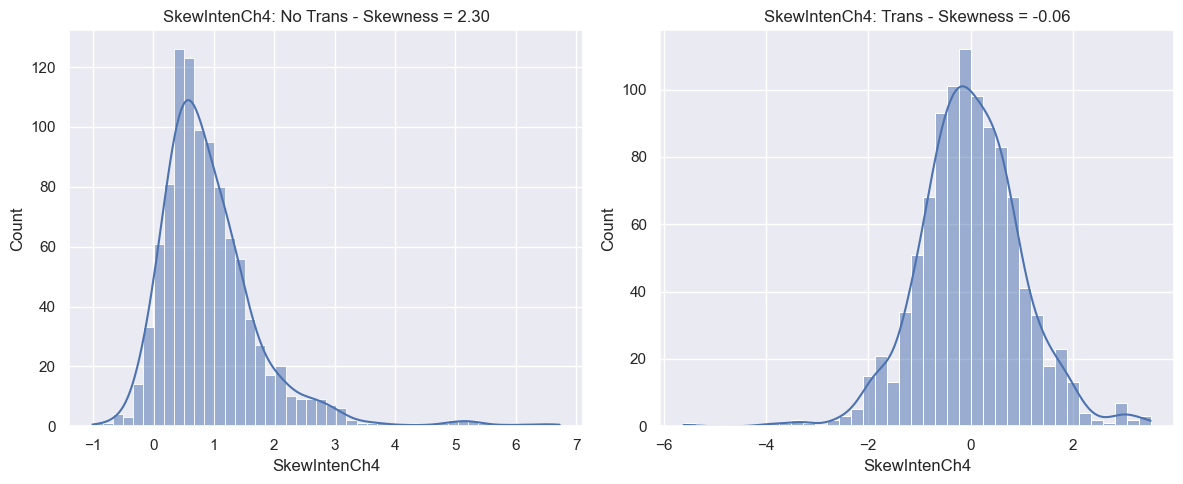

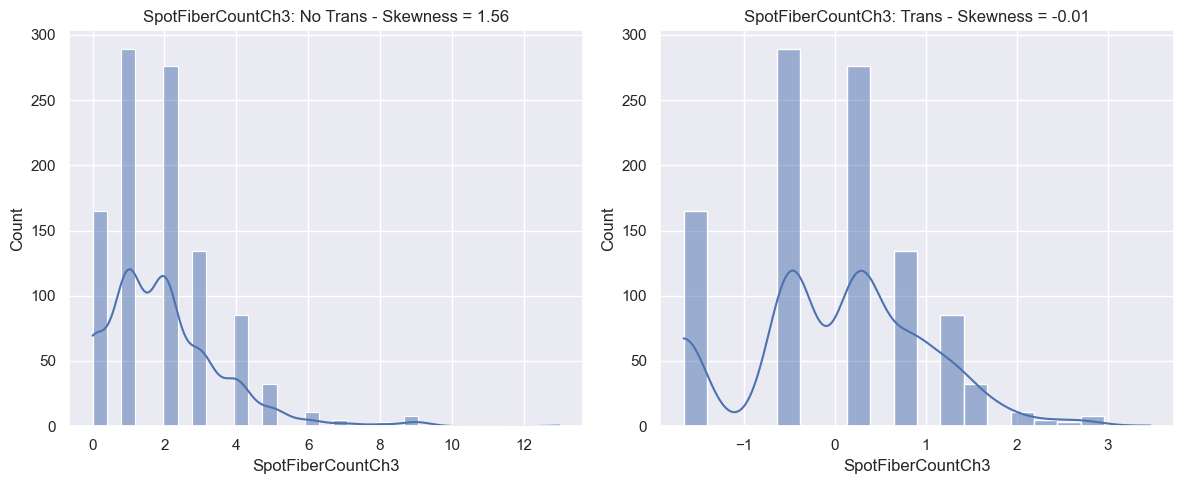

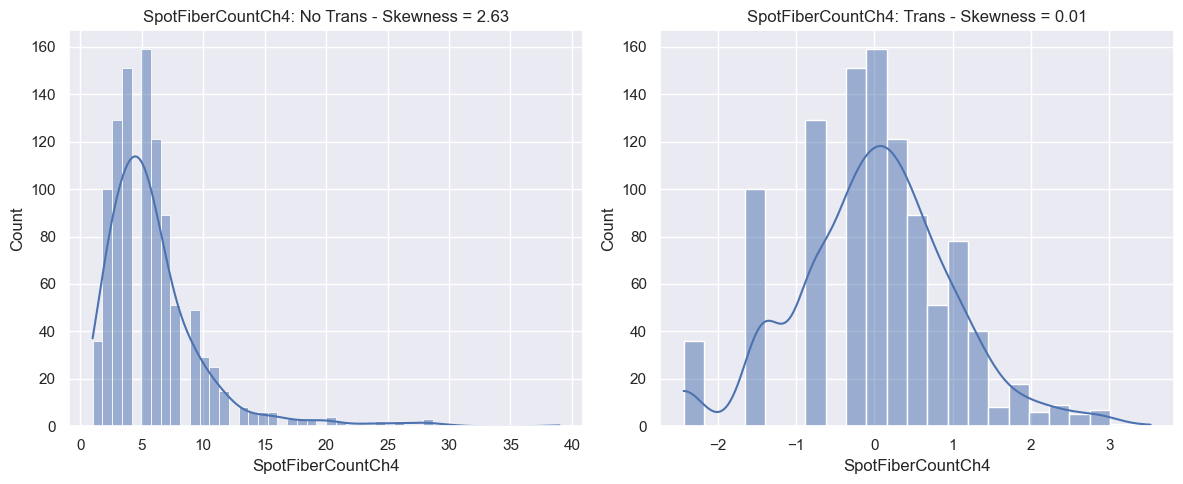

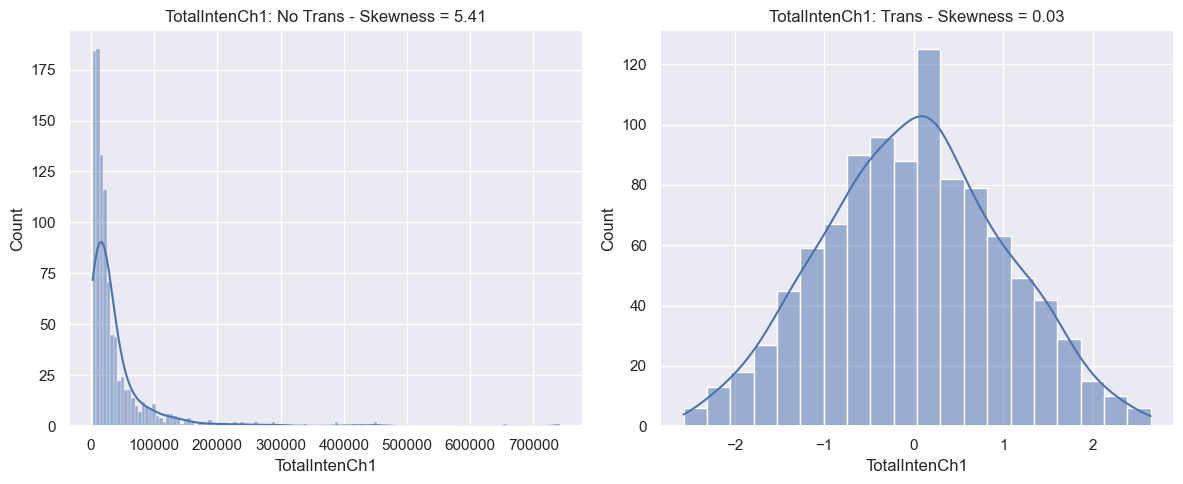

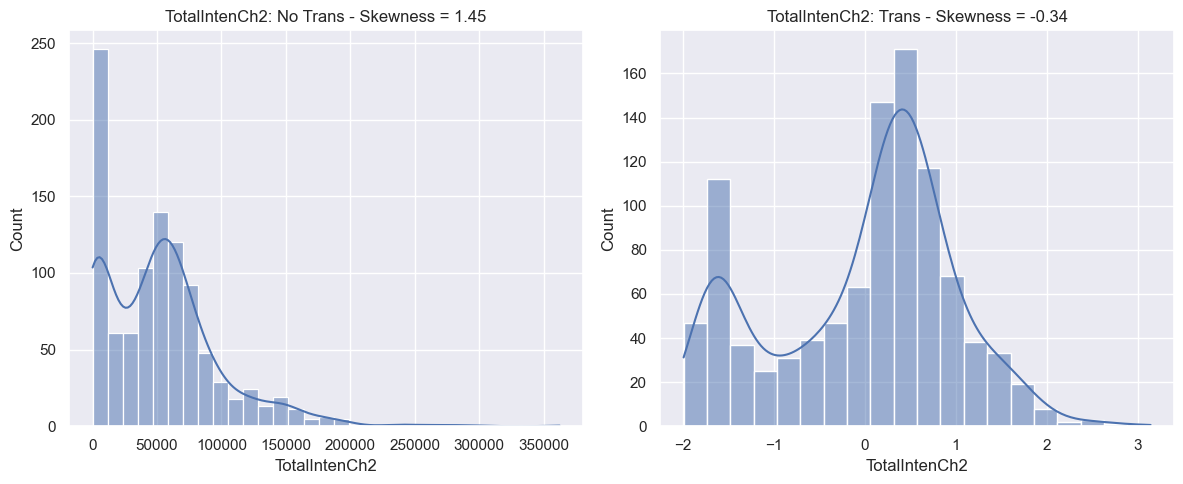

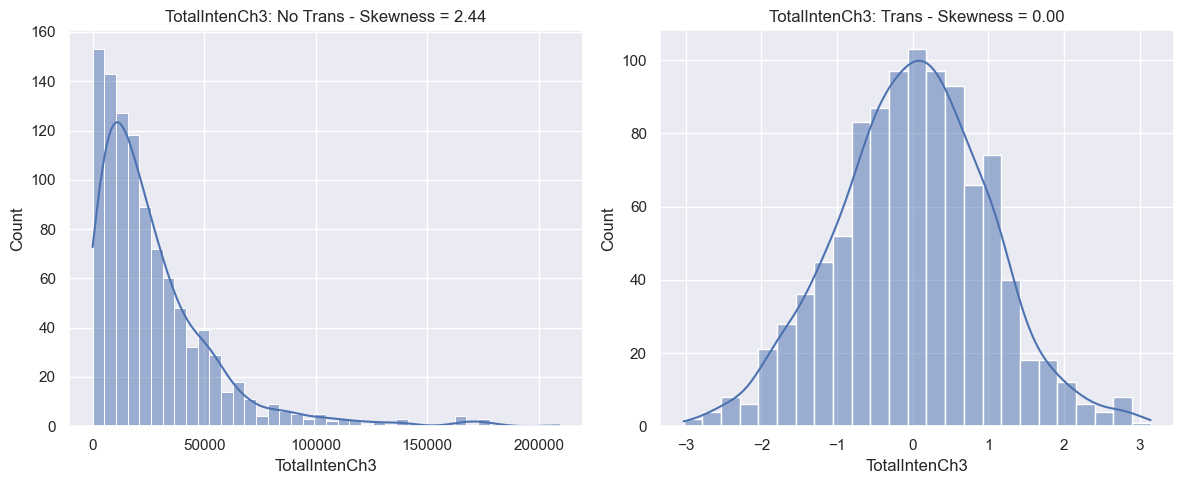

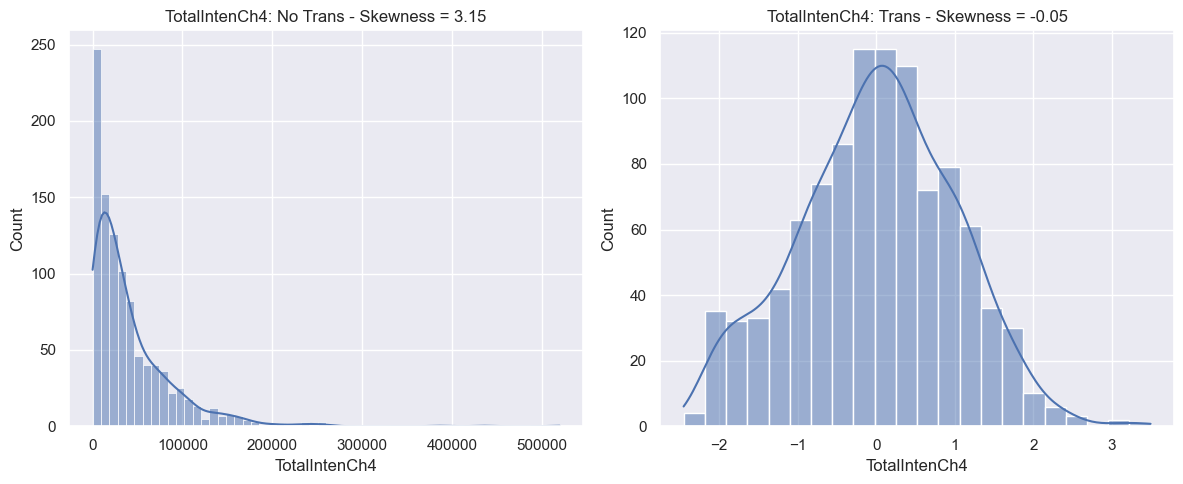

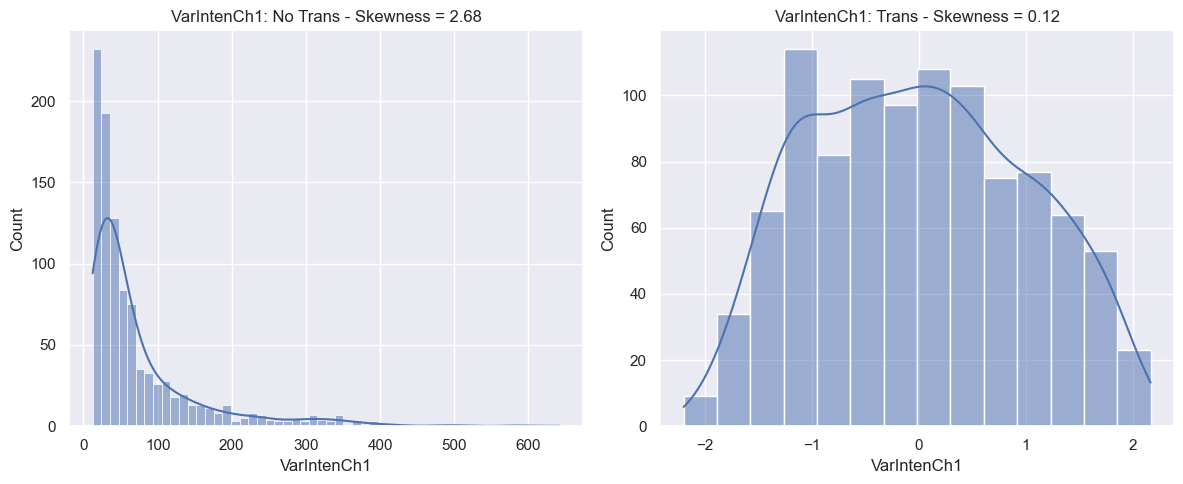

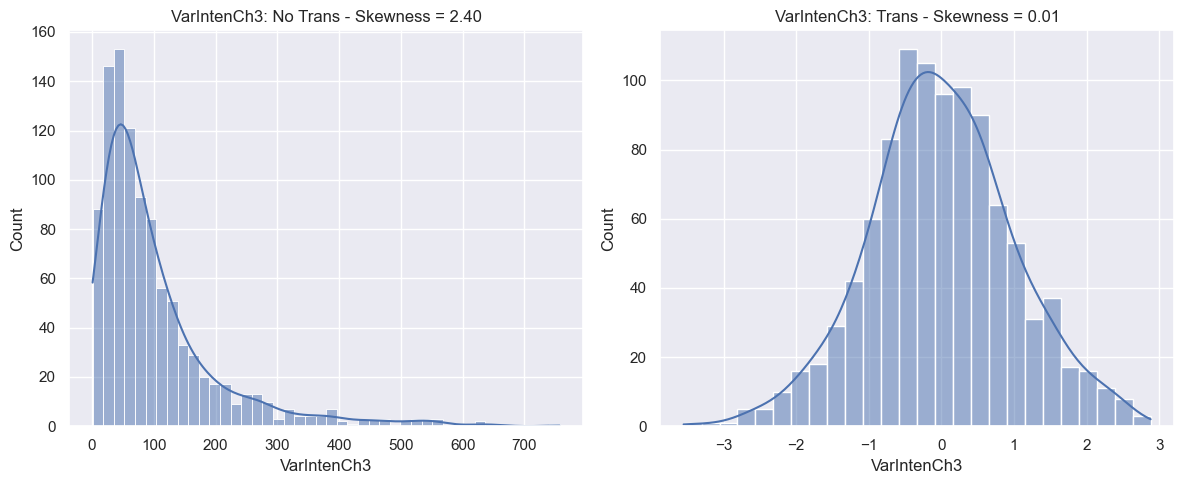

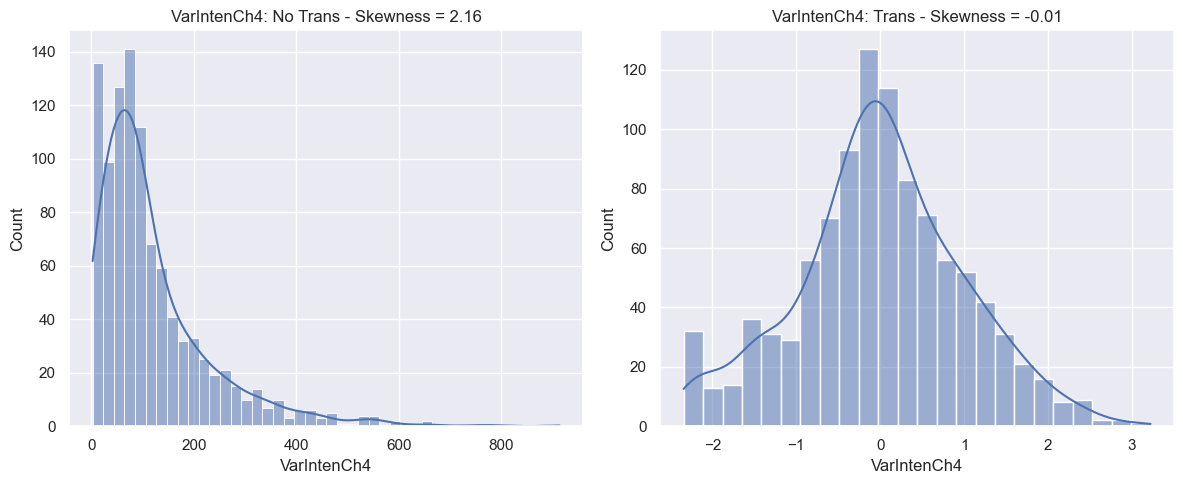

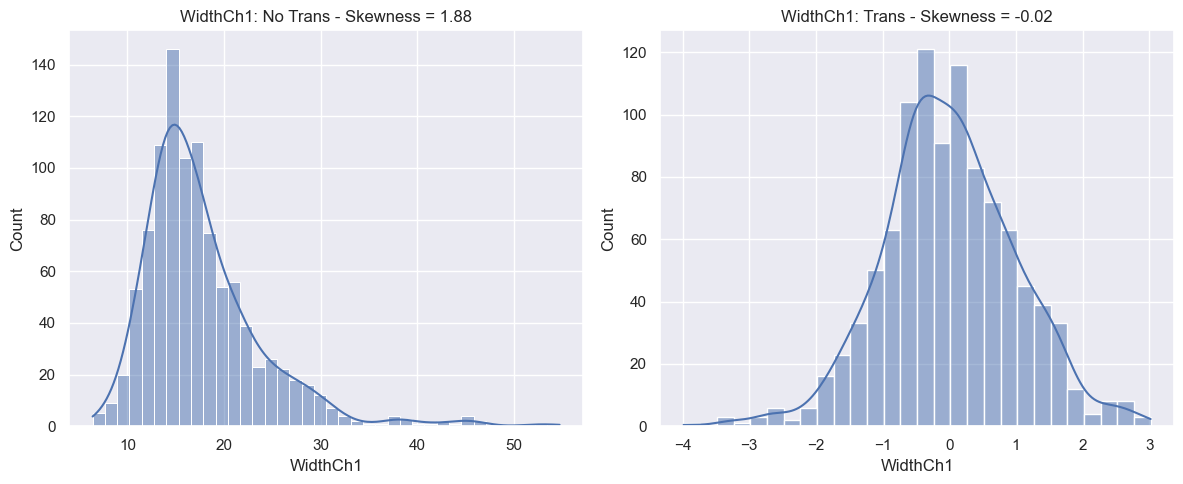

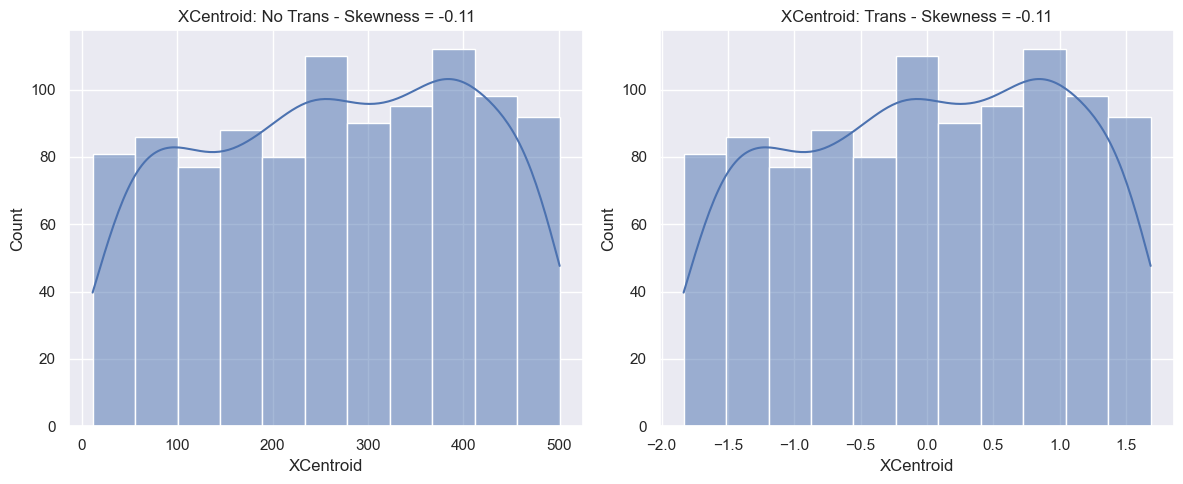

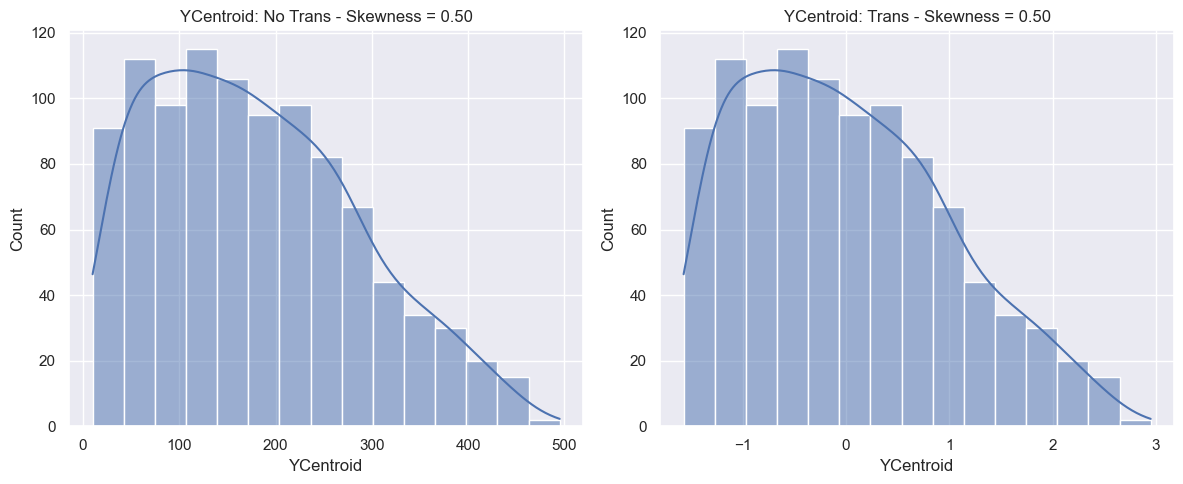

In [14]:
for col in train_df.columns:

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original
    sns.histplot(train_df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col}: No Trans - Skewness = {skew(train_df[col], bias=True):.2f}")
    
    # Transformed - Note that not all columns are transformed.
    sns.histplot(train_df_trans[col], kde=True, ax=axes[1])
    axes[1].set_title(f"{col}: Trans - Skewness = {skew(train_df_trans[col], bias=True):.2f}")
    
    plt.tight_layout()
    plt.show()

### PCA - Principal component analysis

In [15]:
pca = PCA() # Initialize PCA without specifying the number of components
# Note: PCA will automatically determine the number of components based on the data.
pca_scores = pca.fit_transform(train_df_trans) # Fit PCA and transform the data

In [16]:
pca_scores[:5,:5]

array([[ 1.51312888,  6.10077773,  0.90177156, -3.32227174, -1.28221043],
       [-0.7150574 ,  1.9467437 ,  1.59653256, -4.6356783 , -1.84046134],
       [ 3.737897  , -0.3870332 ,  0.51595163, -4.02157079,  1.62776419],
       [ 0.16318887, -2.18223918, -1.65341475, -5.30708949,  0.14176826],
       [ 0.80189537, -1.57809173,  1.02770901, -5.75875827, -1.14867951]])

In [17]:
explained_var = pca.explained_variance_ratio_ * 100  # Percent of variance explained by each PC
cumulative_var = np.cumsum(explained_var) # Cumulative variance explained by PCs
print(explained_var[:15],'\n')  # First 15 PCs
print(cumulative_var[:15])  # Cumulative variance for first 15 PCs

[22.76023578 18.59703736 13.77132056  7.86662074  4.78872402  4.23095394
  3.48491873  3.13795113  2.32131511  1.96221387  1.89933146  1.84494706
  1.67972623  1.52215203  1.48023245] 

[22.76023578 41.35727314 55.1285937  62.99521444 67.78393847 72.01489241
 75.49981114 78.63776227 80.95907737 82.92129125 84.82062271 86.66556977
 88.34529601 89.86744804 91.34768049]


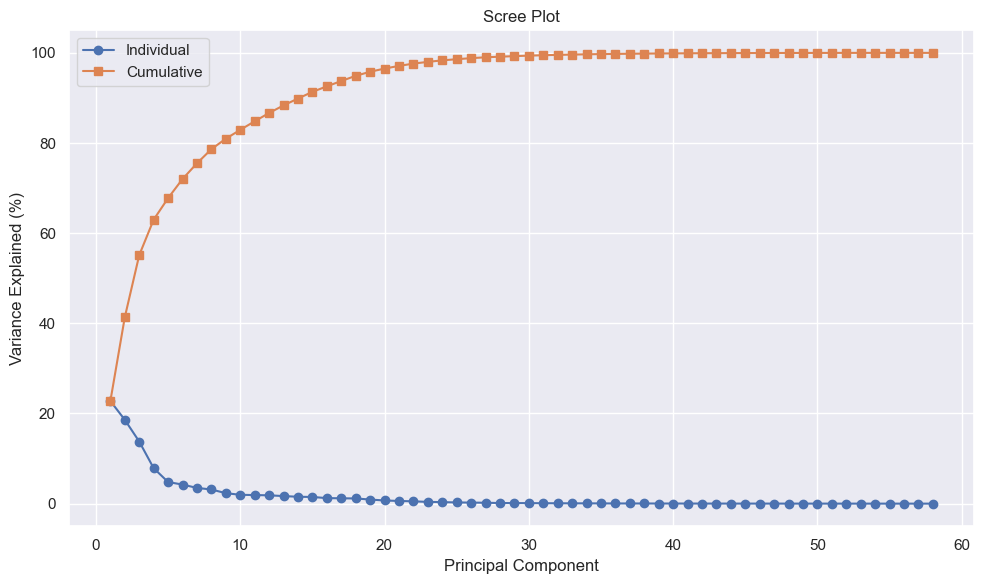

In [18]:
# Make a scree plot
# Note: The scree plot shows the variance explained by each principal component.
# It helps to visualize how many components are needed to explain a certain amount of variance.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', label='Individual')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='s', label='Cumulative')
# plt.axhline(y=60, color='gray', linestyle='--', linewidth=0.8) # Optional line for 60% threshold

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

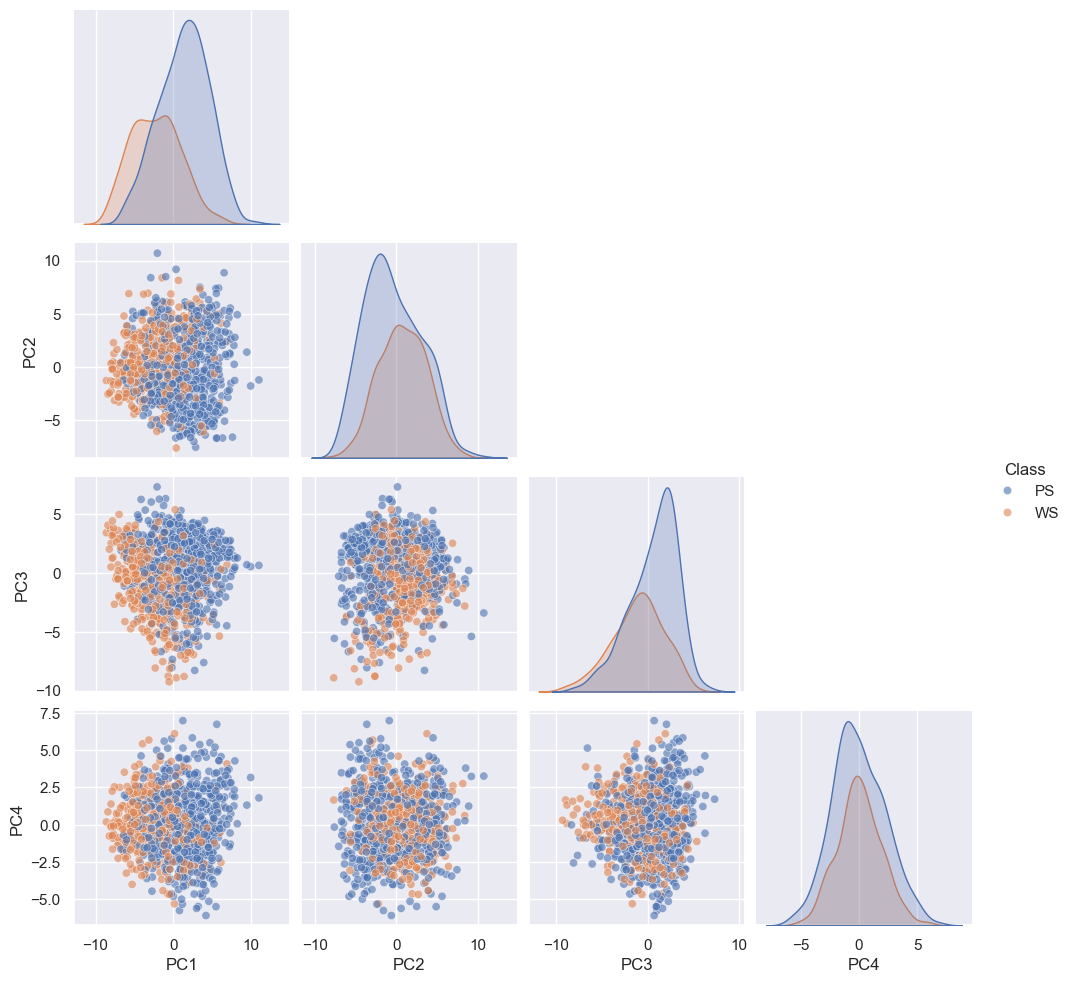

In [19]:
# Combine PCA scores (first 4 PCs) and class labels into a DataFrame
pca_df = pd.DataFrame(pca_scores[:, :4], columns=[f'PC{i+1}' for i in range(4)])
pca_df['Class'] = class_.values  # Add class labels

# Use Seaborn to plot pairwise scatter plots
sns.pairplot(pca_df, hue='Class', corner=True, plot_kws={'alpha': 0.6})


## Filtering

### Near-zero variance

In [20]:
# Check for near-zero variance columns
# This function identifies columns with near-zero variance, which may not be useful for modeling.
problematic_cols = near_zero_var(train_df_trans)
print("Near-zero variance columns:", problematic_cols)

Near-zero variance columns: []


### Correlations between predictors

In [21]:
correlation_matrix = train_df_trans.corr() # Calculate the correlation matrix
correlation_matrix.head()  # Preview the correlation matrix

AngleCh1   AreaCh1  AvgIntenCh1  AvgIntenCh2  AvgIntenCh3  \
AngleCh1     1.000000  0.000638    -0.020910    -0.019739    -0.039559   
AreaCh1      0.000638  1.000000    -0.060389    -0.004847    -0.104438   
AvgIntenCh1 -0.020910 -0.060389     1.000000     0.575585     0.417990   
AvgIntenCh2 -0.019739 -0.004847     0.575585     1.000000     0.072079   
AvgIntenCh3 -0.039559 -0.104438     0.417990     0.072079     1.000000   

             AvgIntenCh4  ConvexHullAreaRatioCh1  ConvexHullPerimRatioCh1  \
AngleCh1       -0.032819               -0.043547                 0.044002   
AreaCh1         0.060411                0.291731                -0.429944   
AvgIntenCh1     0.452044               -0.445228                 0.524028   
AvgIntenCh2     0.619285               -0.569642                 0.461892   
AvgIntenCh3     0.393224                0.079548                 0.014631   

             DiffIntenDensityCh1  DiffIntenDensityCh3  ...  TotalIntenCh1  \
AngleCh1               -0.047268            -0.044469  ...      -0.024798   
AreaCh1                -0.083621            -0.113894  ...       0.414588   
AvgIntenCh1             0.957081             0.394751  ...       0.872217   
AvgIntenCh2             0.499399             0.040000  ...       0.521294   
AvgIntenCh3             0.493730             0.969297  ...       0.328359   

             TotalIntenCh2  TotalIntenCh3  TotalIntenCh4  VarIntenCh1  \
AngleCh1         -0.013583      -0.032878      -0.030353    -0.042900   
AreaCh1           0.375597       0.347575       0.419039    -0.008704   
AvgIntenCh1       0.499281       0.348479       0.378845     0.964684   
AvgIntenCh2       0.901674       0.052716       0.547331     0.506296   
AvgIntenCh3       0.030624       0.882196       0.321375     0.476073   

             VarIntenCh3  VarIntenCh4  WidthCh1  XCentroid  YCentroid  
AngleCh1       -0.035182    -0.045213 -0.062720  -0.056506  -0.055270  
AreaCh1        -0.037770     0.104170  0.765789  -0.025815  -0.144427  
AvgIntenCh1     0.510632     0.440318 -0.045186  -0.090050  -0.094070  
AvgIntenCh2     0.187812     0.619411  0.079574  -0.039218  -0.075131  
AvgIntenCh3     0.921352     0.392503 -0.037779   0.023370   0.006361  

[5 rows x 58 columns]

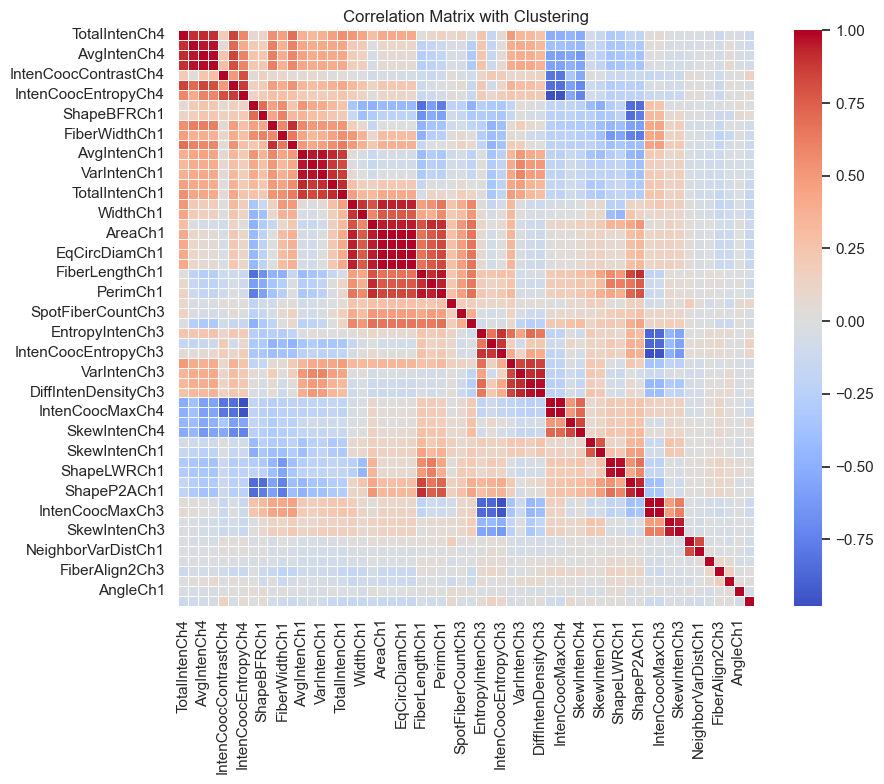

In [22]:
correlation_matrix = plot_corr(train_df_trans)

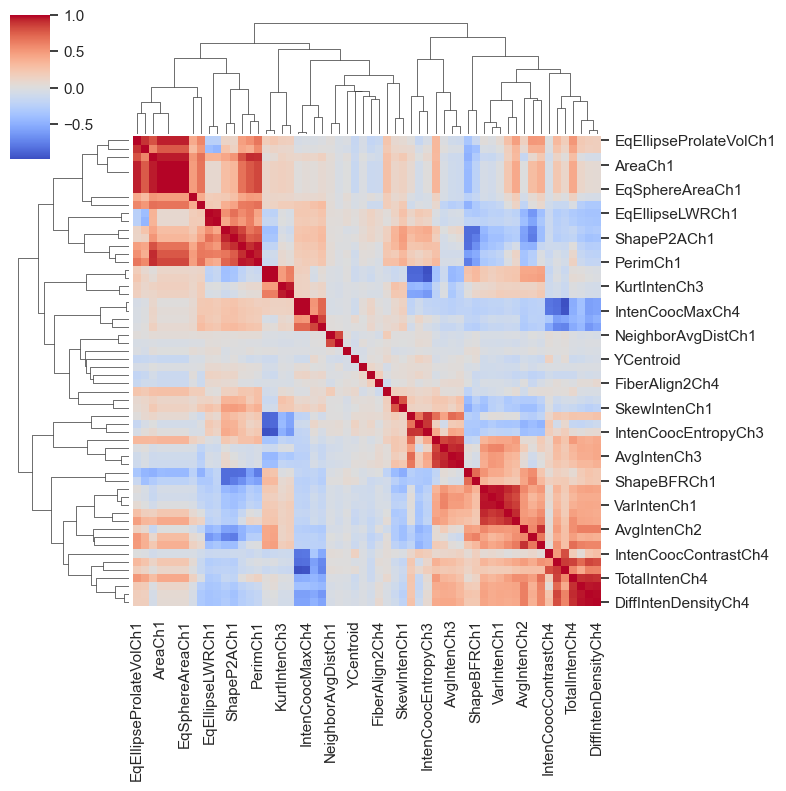

In [23]:
# Alternative visualization using a clustermap
# This will create a clustered heatmap with dendrograms
sns.clustermap(train_df_trans.corr(), cmap='coolwarm', center=0, figsize=(8, 8))

### Filtering on correlation threshold

In [24]:
# Find highly correlated columns - cutoff is used to suggest columns for removal
high_corr_cols = find_correlation(train_df_trans, cutoff=0.75)
print(len(high_corr_cols), "columns will be removed")

filtered_df = train_df_trans.drop(columns=high_corr_cols)


34 columns will be removed


In [25]:
filtered_df.head()  # Preview the filtered DataFrame

AngleCh1  AvgIntenCh2  ConvexHullPerimRatioCh1  EntropyIntenCh3  \
1   0.871910     0.393103                -1.341483         0.856299   
2   0.317462    -0.146477                 0.476915         0.894408   
3  -0.449522    -0.249520                -0.641716        -0.173436   
11  0.374123    -0.073006                 0.192639        -1.033484   
14  0.269030    -0.083641                 0.395223        -0.135443   

    FiberAlign2Ch3  FiberAlign2Ch4  FiberWidthCh1  IntenCoocContrastCh3  \
1         0.119391       -0.330041       0.908661              0.048539   
2        -0.625197        0.369221       2.107661              0.800503   
3        -0.943425        1.237156      -0.721618             -0.092161   
11       -0.372063        0.198677       0.672189             -0.281091   
14       -0.391203       -0.774703       0.203028              0.212818   

    IntenCoocContrastCh4  KurtIntenCh1  ...  ShapeBFRCh1  ShapeLWRCh1  \
1               0.139039     -0.256498  ...    -0.503067    -0.363975   
2               1.504955     -0.320521  ...     1.282647    -0.748792   
3               1.123861      0.543464  ...    -0.025039     1.402951   
11              0.746231     -0.428164  ...     0.416460    -0.793275   
14              0.703425     -0.753039  ...    -0.336218    -0.309590   

    SpotFiberCountCh3  SpotFiberCountCh4  VarIntenCh1  VarIntenCh3  \
1            1.264892           1.306221    -1.328661    -0.217726   
2            0.271805           0.305769    -1.489059    -0.623878   
3            1.264892           0.556504    -1.946379    -0.841131   
11          -1.660543           0.012414    -1.930412    -1.276625   
14          -0.472477          -0.341960    -2.196320    -1.320268   

    VarIntenCh4  WidthCh1  XCentroid  YCentroid  
1      0.324776  1.893757  -0.367980   1.569215  
2     -0.521347  0.782009   0.752728   0.683460  
3     -1.071324 -0.726763   1.586075   1.084381  
11    -0.693719  0.202073  -0.396716   2.949129  
14    -0.661635  0.222793  -0.676893   0.263892  

[5 rows x 24 columns]

## PCA on filtered data

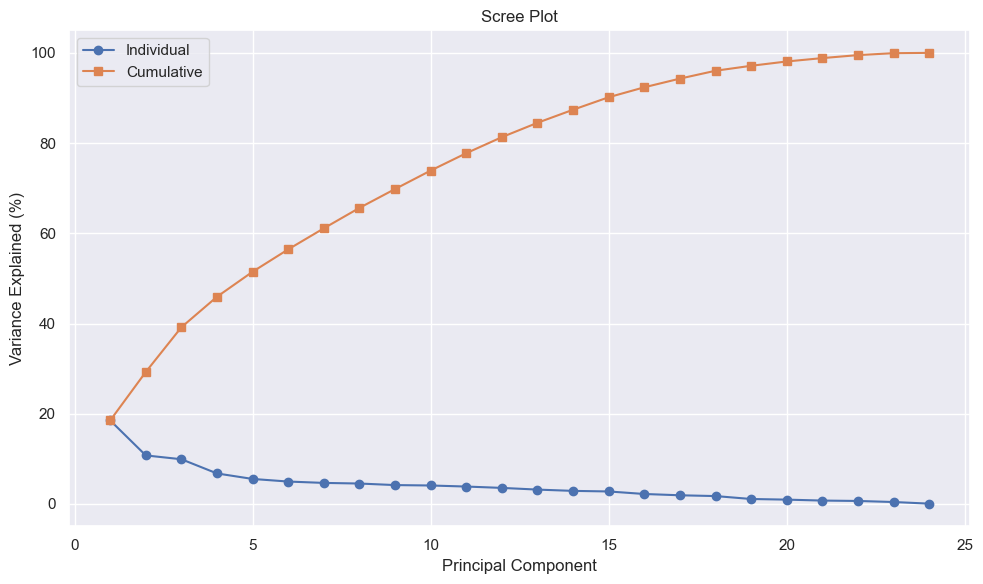

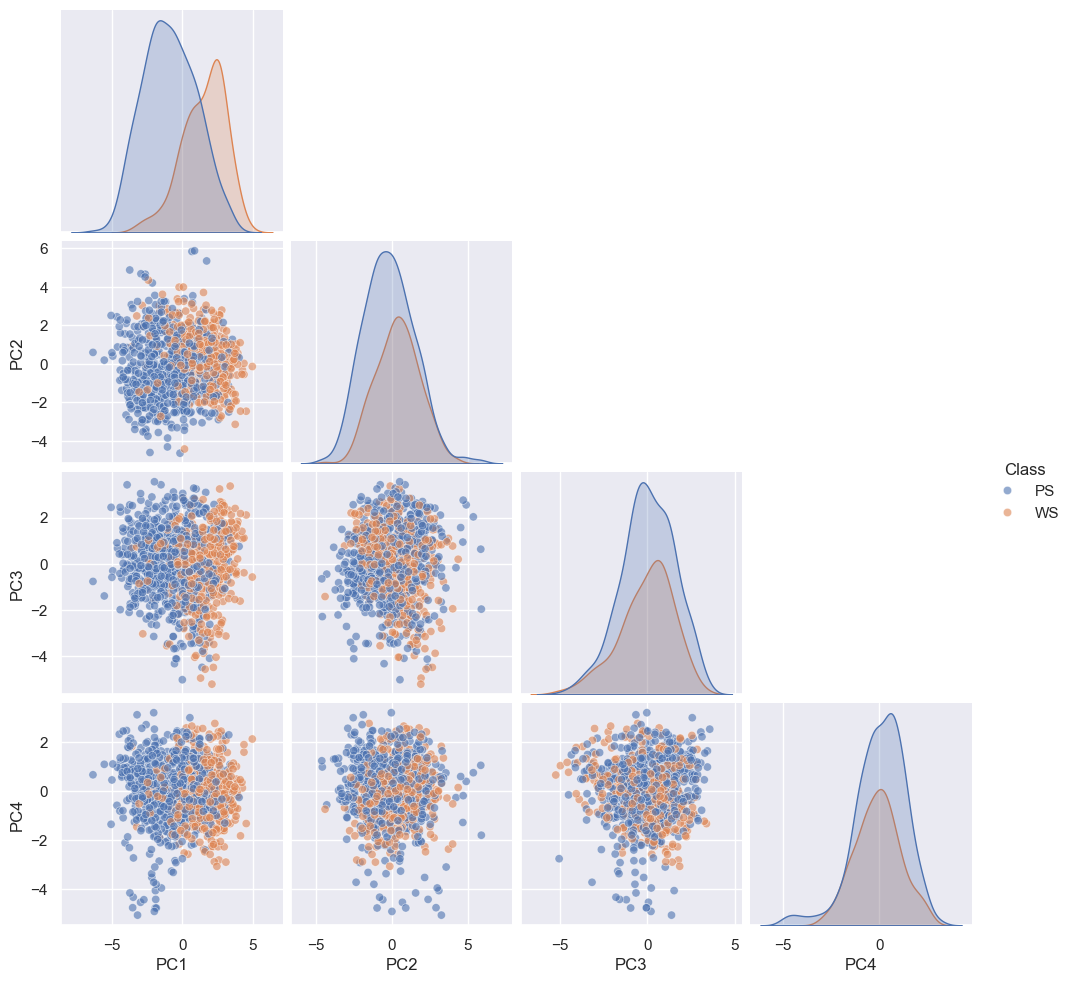

In [26]:
pca_filt = PCA()
pca_filt_scores = pca_filt.fit_transform(filtered_df)

explained_var_filt = pca_filt.explained_variance_ratio_ * 100  # percent
cumulative_var_filt = np.cumsum(explained_var_filt)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var_filt) + 1), explained_var_filt, marker='o', label='Individual')
plt.plot(range(1, len(cumulative_var_filt) + 1), cumulative_var_filt, marker='s', label='Cumulative')
# plt.axhline(y=90, color='gray', linestyle='--', linewidth=0.8)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combine PCA scores (first 4 PCs) and class labels into a DataFrame
pca_df_filt = pd.DataFrame(pca_filt_scores[:, :4], columns=[f'PC{i+1}' for i in range(4)])
pca_df_filt['Class'] = class_.values  # Add class labels

# Use Seaborn to plot pairwise scatter plots
sns.pairplot(pca_df_filt, hue='Class', corner=True, plot_kws={'alpha': 0.6})

## Dummy variables

Using the dataset "cars" from the caret package to illustrate dummy variables.

### Initial inspection and conversion to match data structure in book

In [27]:
cars.info()
samplesize = 100  # Number of samples to take from the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        804 non-null    float64
 1   Mileage      804 non-null    int32  
 2   Cylinder     804 non-null    int32  
 3   Doors        804 non-null    int32  
 4   Cruise       804 non-null    int32  
 5   Sound        804 non-null    int32  
 6   Leather      804 non-null    int32  
 7   Buick        804 non-null    int32  
 8   Cadillac     804 non-null    int32  
 9   Chevy        804 non-null    int32  
 10  Pontiac      804 non-null    int32  
 11  Saab         804 non-null    int32  
 12  Saturn       804 non-null    int32  
 13  convertible  804 non-null    int32  
 14  coupe        804 non-null    int32  
 15  hatchback    804 non-null    int32  
 16  sedan        804 non-null    int32  
 17  wagon        804 non-null    int32  
dtypes: float64(1), int32(17)
memory usage: 59.8 KB


In [28]:
cars.head()  # Quick peek at the data

Price  Mileage  Cylinder  Doors  Cruise  Sound  Leather  Buick  \
0  22661.05    20105         6      4       1      0        0      1   
1  21725.01    13457         6      2       1      1        0      0   
2  29142.71    31655         4      2       1      1        1      0   
3  30731.94    22479         4      2       1      0        0      0   
4  33358.77    17590         4      2       1      1        1      0   

   Cadillac  Chevy  Pontiac  Saab  Saturn  convertible  coupe  hatchback  \
0         0      0        0     0       0            0      0          0   
1         0      1        0     0       0            0      1          0   
2         0      0        0     1       0            1      0          0   
3         0      0        0     1       0            1      0          0   
4         0      0        0     1       0            1      0          0   

   sedan  wagon  
0      1      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0

In [29]:
# Create dummy variable Type that indicates the type of car based on the columns 13 to 17
type_labels = ["convertible", "coupe", "hatchback", "sedan", "wagon"]

# Apply logic to determine type based on which column is 1
cars['Type'] = cars[type_labels].idxmax(axis=1)

# Random sample of columns of interest
car_subset = cars.sample(n=samplesize, random_state=42)[['Price', 'Mileage', 'Type']]
print(car_subset)

        Price  Mileage   Type
192  21403.76    27168  sedan
717  16713.98    26328  sedan
168  16569.14    25777  sedan
522  19116.13    26252  sedan
536  16379.10     8754  wagon
..        ...      ...    ...
483  18620.87    25516  sedan
784  22460.53     8928  sedan
259  16345.94    25931  coupe
611  17944.86    19592  sedan
211  19191.99    29187  sedan

[100 rows x 3 columns]


### Price ~ Mileage + Type

In [30]:
# Define a transformer that leaves Mileage as-is, and one-hot encodes Type
simple_transformer = ColumnTransformer(
    transformers=[
        ('mileage', 'passthrough', ['Mileage']),
        ('type', OneHotEncoder(drop=None, sparse_output=False), ['Type'])
    ]
)

# Apply it to the subset
X_simple = simple_transformer.fit_transform(car_subset)
feature_names_simple = ['Mileage'] + list(simple_transformer.named_transformers_['type'].get_feature_names_out(['Type']))
X_simple_df = pd.DataFrame(X_simple, columns=feature_names_simple)

X_simple_df.head()

Mileage  Type_convertible  Type_coupe  Type_hatchback  Type_sedan  \
0  27168.0               0.0         0.0             0.0         1.0   
1  26328.0               0.0         0.0             0.0         1.0   
2  25777.0               0.0         0.0             0.0         1.0   
3  26252.0               0.0         0.0             0.0         1.0   
4   8754.0               0.0         0.0             0.0         0.0   

   Type_wagon  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         1.0

#### Linear prediction

RMSE on training data: 8189.34


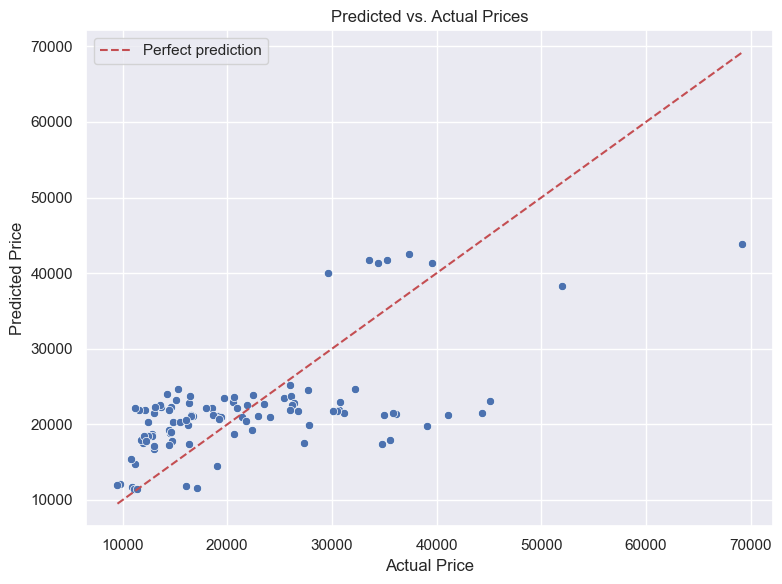

In [31]:
# Step 1: Define the target variable
y = car_subset['Price']

# Step 2: Fit a linear regression model
model = LinearRegression()
model.fit(X_simple_df, y)

# Step 3: Predict on the training data
predictions = model.predict(X_simple_df)

# Step 4: Evaluate
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"RMSE on training data: {rmse:.2f}")

# Plot predicted vs actual prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Add interaction terms — Price ~ Mileage + Type + Mileage:Type

In [32]:
# Create dummy variables first
dummies = pd.get_dummies(car_subset['Type'], prefix='Type')
print(f"dummies ({type(dummies)}):\n",dummies.head())

# Combine Mileage and dummies
X_base = pd.concat([car_subset[['Mileage']], dummies], axis=1)

# Now create interactions (we only want 2-way interactions: Mileage * Type_xxx)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_base)

# Create feature names
input_features = X_base.columns
interaction_feature_names = poly.get_feature_names_out(input_features)

# Wrap in DataFrame
X_interaction_df = pd.DataFrame(X_interaction, columns=interaction_feature_names)

# Drop columns by index - These are Type_xxx * Type_yyy interactions
cols_to_drop = X_interaction_df.columns[11:]
X_interaction_df = X_interaction_df.drop(cols_to_drop, axis=1)
X_interaction_df.head()  # Preview the DataFrame after dropping columns

dummies (<class 'pandas.core.frame.DataFrame'>):
      Type_convertible  Type_coupe  Type_hatchback  Type_sedan  Type_wagon
192             False       False           False        True       False
717             False       False           False        True       False
168             False       False           False        True       False
522             False       False           False        True       False
536             False       False           False       False        True


Mileage  Type_convertible  Type_coupe  Type_hatchback  Type_sedan  \
0  27168.0               0.0         0.0             0.0         1.0   
1  26328.0               0.0         0.0             0.0         1.0   
2  25777.0               0.0         0.0             0.0         1.0   
3  26252.0               0.0         0.0             0.0         1.0   
4   8754.0               0.0         0.0             0.0         0.0   

   Type_wagon  Mileage Type_convertible  Mileage Type_coupe  \
0         0.0                       0.0                 0.0   
1         0.0                       0.0                 0.0   
2         0.0                       0.0                 0.0   
3         0.0                       0.0                 0.0   
4         1.0                       0.0                 0.0   

   Mileage Type_hatchback  Mileage Type_sedan  Mileage Type_wagon  
0                     0.0             27168.0                 0.0  
1                     0.0             26328.0                 0.0  
2                     0.0             25777.0                 0.0  
3                     0.0             26252.0                 0.0  
4                     0.0                 0.0              8754.0

RMSE on training data: 8098.11


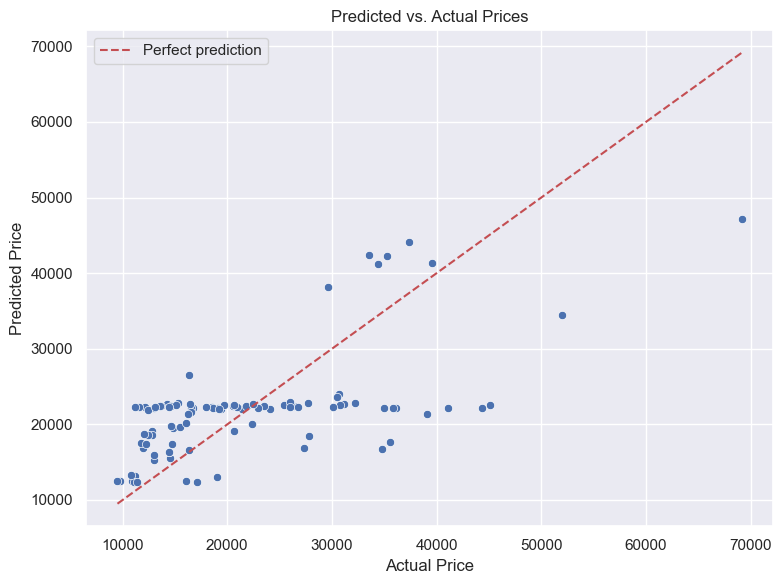

In [33]:
# Step 1: Define the target variable
y = car_subset['Price']

# Step 2: Fit a linear regression model
model = LinearRegression()
model.fit(X_interaction_df, y)

# Step 3: Predict on the training data
predictions = model.predict(X_interaction_df)

# Step 4: Evaluate (optional)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"RMSE on training data: {rmse:.2f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Add remaining variables - No interaction

RMSE on training data: 2651.54


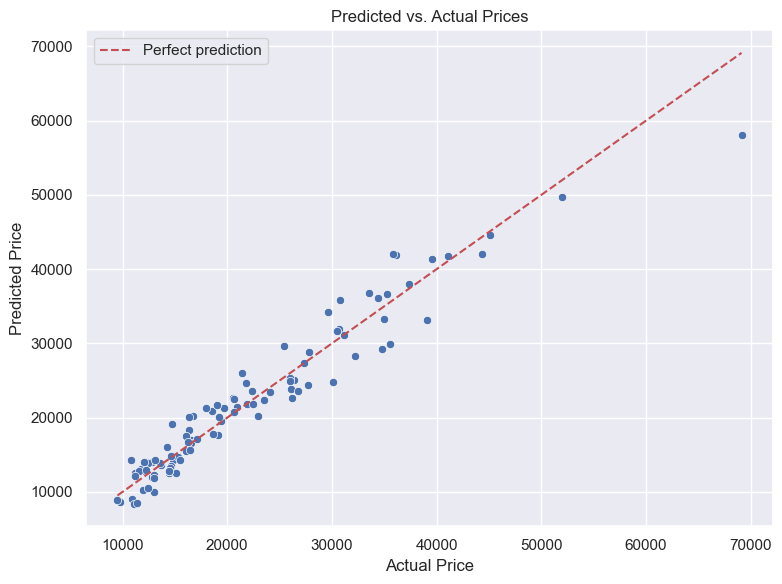

In [34]:
# Create dummy variable Type that indicates the type of car based on the columns 13 to 17
brand_labels = ["Buick", "Cadillac", "Chevy", "Pontiac", "Saab", "Saturn"] # 7-12
type_labels = ["convertible", "coupe", "hatchback", "sedan", "wagon"]


# Apply logic to determine type based on which column is 1
cars['Brand'] = cars[brand_labels].idxmax(axis=1)
cars['Type'] = cars[type_labels].idxmax(axis=1)

# Random sample of columns of interest
car_subset_ext = cars.sample(n=samplesize, random_state=42)[['Price', 'Mileage', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather', 'Brand', 'Type']]

# Define a transformer that one-hot encodes Type and Brand and leaves other feature columns as-is
simple_transformer = ColumnTransformer(
    transformers=[
        ('mileage', 'passthrough', ['Mileage']),
        ('Cylinder', 'passthrough', ['Cylinder']),
        ('Doors', 'passthrough', ['Doors']),
        ('Cruise', 'passthrough', ['Cruise']),
        ('Sound', 'passthrough', ['Sound']),
        ('Leather', 'passthrough', ['Leather']),
        ('brand', OneHotEncoder(drop=None, sparse_output=False), ['Brand']),
        ('type', OneHotEncoder(drop=None, sparse_output=False), ['Type'])
    ]
)

# Apply it to the subset
X_simple_ext = simple_transformer.fit_transform(car_subset_ext)
feature_names_simple_ext = ['Mileage', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather'] + list(simple_transformer.named_transformers_['brand'].get_feature_names_out(['Brand'])) + list(simple_transformer.named_transformers_['type'].get_feature_names_out(['Type']))
X_simple_df_ext = pd.DataFrame(X_simple_ext, columns=feature_names_simple_ext)
X_simple_df_ext.head()  # Preview the DataFrame 

# Step 1: Define the target variable
y = car_subset_ext['Price']

# Step 2: Fit a linear regression model
model = LinearRegression()
model.fit(X_simple_df_ext, y)

# Step 3: Predict on the training data (or new data)
predictions = model.predict(X_simple_df_ext)

# Step 4: Evaluate
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"RMSE on training data: {rmse:.2f}")

# Plot predicted vs actual prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exercises

### E: 3.1
A. Using visualizations, explore the predictor variables to understand their distributions as well as the relationships between predictors.

B. Do there appear to be any outliers in the data? Are any predictors skewed?

C. Are there any relevant transformations of one or more predictors that
might improve the classification model?

#### Investigate data

In [35]:
glass.head()  # Quick peek at the data

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0    1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0    1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0    1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0    1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0    1

In [36]:
glass.info()  # Get information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   RI      214 non-null    float64 
 1   Na      214 non-null    float64 
 2   Mg      214 non-null    float64 
 3   Al      214 non-null    float64 
 4   Si      214 non-null    float64 
 5   K       214 non-null    float64 
 6   Ca      214 non-null    float64 
 7   Ba      214 non-null    float64 
 8   Fe      214 non-null    float64 
 9   Type    214 non-null    category
dtypes: category(1), float64(9)
memory usage: 15.6 KB


#### Correlation between predictors

In [37]:
correlation_matrix = glass.corr() # Calculate the correlation matrix
correlation_matrix.head()  # Preview the correlation matrix

RI        Na        Mg        Al        Si         K        Ca  \
RI  1.000000 -0.191885 -0.122274 -0.407326 -0.542052 -0.289833  0.810403   
Na -0.191885  1.000000 -0.273732  0.156794 -0.069809 -0.266087 -0.275442   
Mg -0.122274 -0.273732  1.000000 -0.481799 -0.165927  0.005396 -0.443750   
Al -0.407326  0.156794 -0.481799  1.000000 -0.005524  0.325958 -0.259592   
Si -0.542052 -0.069809 -0.165927 -0.005524  1.000000 -0.193331 -0.208732   

          Ba        Fe      Type  
RI -0.000386  0.143010 -0.164237  
Na  0.326603 -0.241346  0.502898  
Mg -0.492262  0.083060 -0.744993  
Al  0.479404 -0.074402  0.598829  
Si -0.102151 -0.094201  0.151565

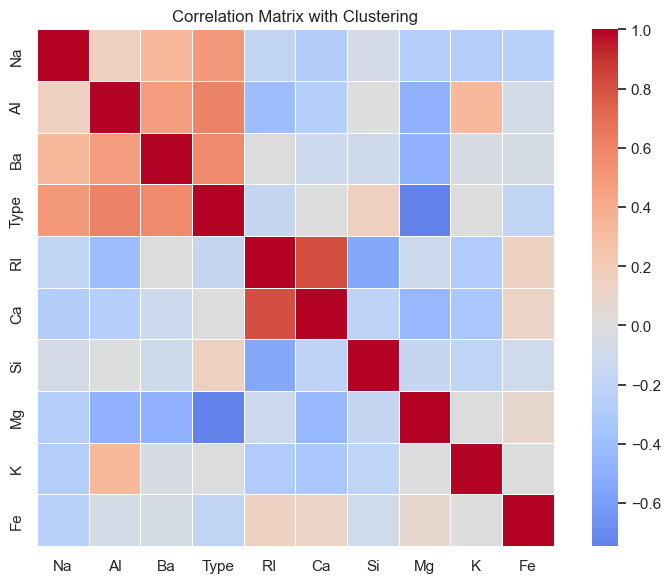

In [38]:
correlation_matrix = plot_corr(glass, figsize=(8, 6))

In [39]:
# Find highly correlated columns - cutoff is used to suggest columns for removal
high_corr_cols = find_correlation(glass, cutoff=0.75)
print(len(high_corr_cols), "column(s) suggested for filtering")
print(high_corr_cols)  # Print the names of the highly correlated columns

1 column(s) suggested for filtering
['RI']


#### Transform data
The histplot below demonstrates that RI has very little variance due to the small scale. Box-cox will have issues due to numerical precision. Thus, we use standardscaler first which centers and imposes unit variance. This will introduce negative values (due to the centering) meaning check_transform_suitability and selective_transform will utilize yeo-johnson rather than box-cox.

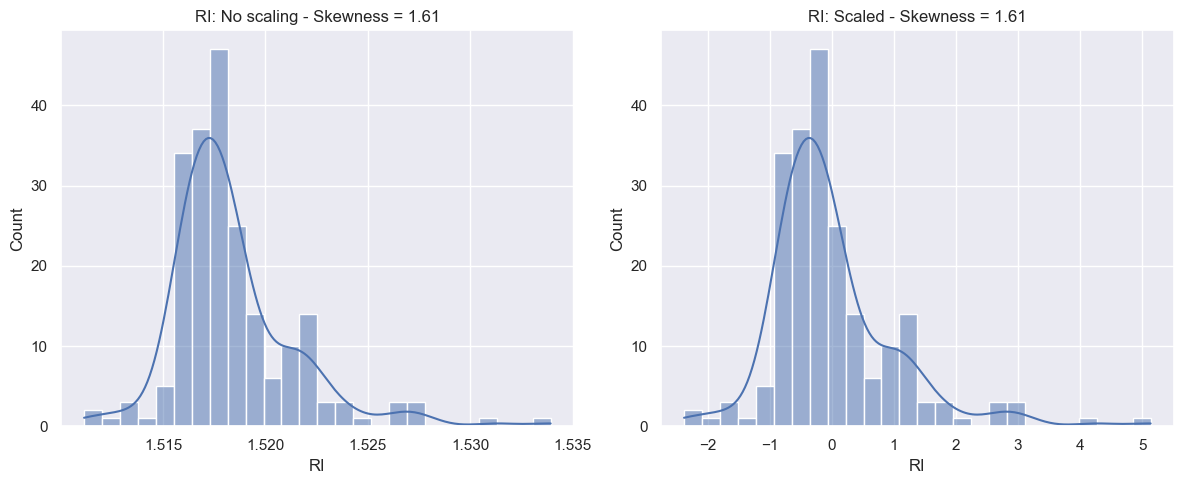

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
# Original
sns.histplot(glass["RI"], kde=True, ax=axes[0])
axes[0].set_title(f"RI: No scaling - Skewness = {skew(glass['RI'], bias=True):.2f}")

# Create new dataframe with scaling for RI
glass_ws = glass
glass_ws["RI"] = StandardScaler().fit_transform(glass[['RI']])

sns.histplot(glass_ws["RI"], kde=True, ax=axes[1])
axes[1].set_title(f"RI: Scaled - Skewness = {skew(glass_ws['RI'], bias=True):.2f}")

plt.tight_layout()
plt.show()

In [41]:
# Apply transformation suitability check
summary_df, boxcox_cols, yeojohnson_cols = check_transform_suitability(glass_ws, save_csv=True)
summary_df.head(10)  # Preview the summary DataFrame

Summary saved to transform_suitability.csv


Column Data Type  Skewness  Apply Transformation  Box-Cox Applicable  \
0     RI   float64  1.614015                  True               False   
1     Na   float64  0.450992                 False                True   
2     Mg   float64 -1.144465                  True               False   
3     Al   float64  0.900918                  True                True   
4     Si   float64 -0.725317                  True                True   
5      K   float64  6.505636                  True               False   
6     Ca   float64  2.032677                  True                True   
7     Ba   float64  3.392431                  True               False   
8     Fe   float64  1.742007                  True               False   
9   Type  category       NaN                 False               False   

   Yeo-Johnson Applicable  NaN Count  NaN %  
0                    True          0  0.00%  
1                    True          0  0.00%  
2                    True          0  0.00%  
3                    True          0  0.00%  
4                    True          0  0.00%  
5                    True          0  0.00%  
6                    True          0  0.00%  
7                    True          0  0.00%  
8                    True          0  0.00%  
9                   False          0  0.00%

In [42]:
# Apply selective transformation based on the summary DataFrame
glass_trans = selective_transform(glass_ws, summary_df) 

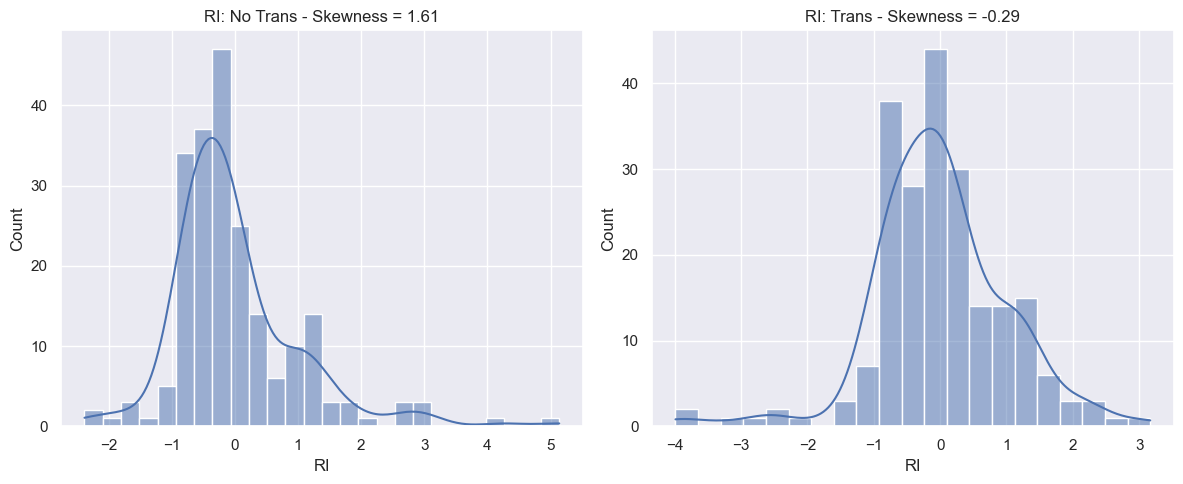

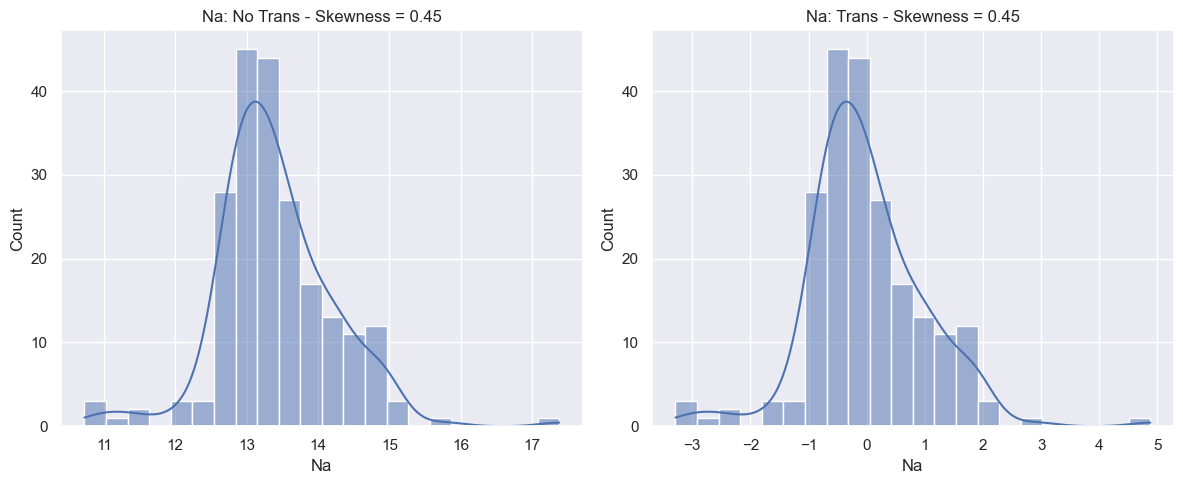

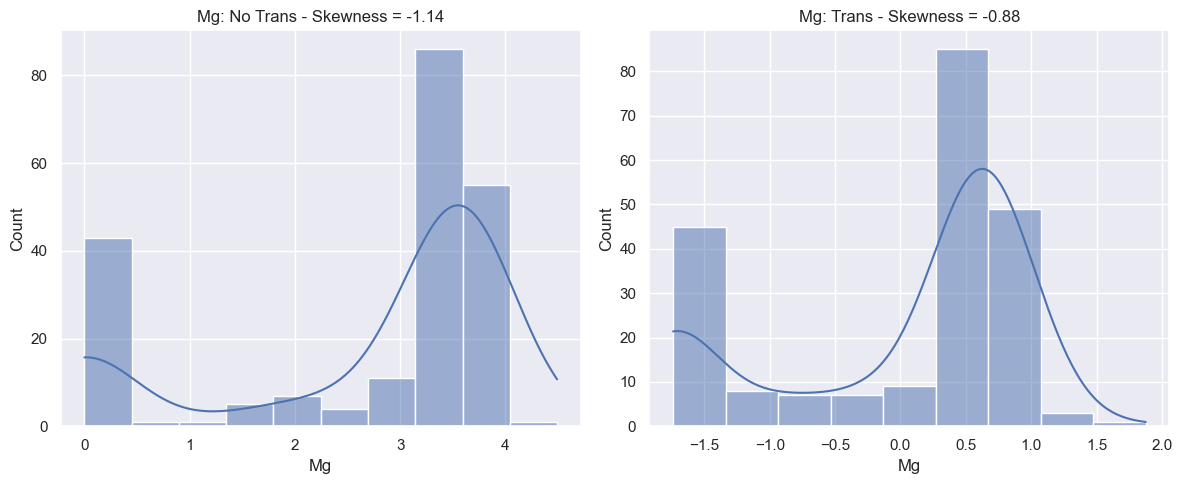

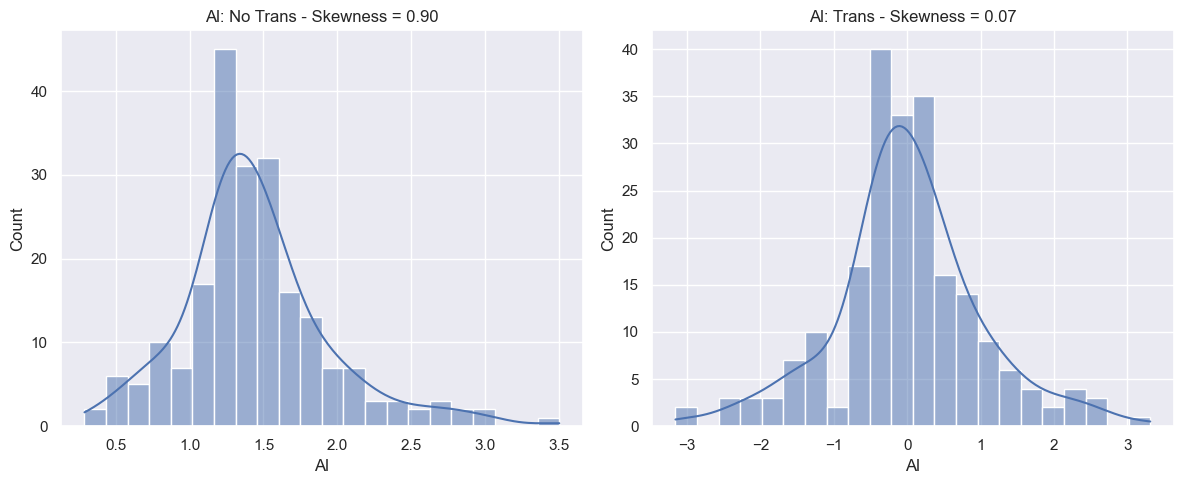

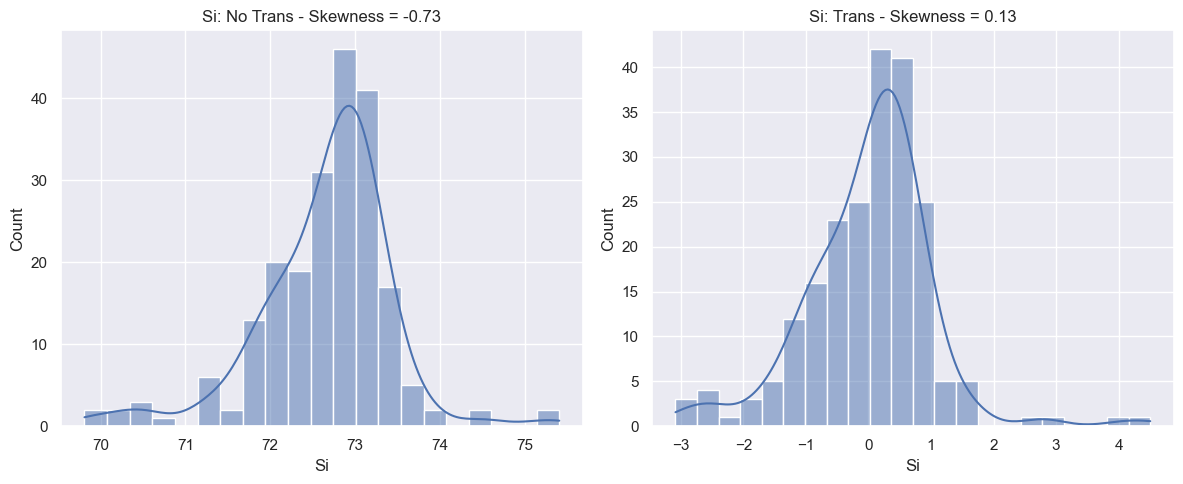

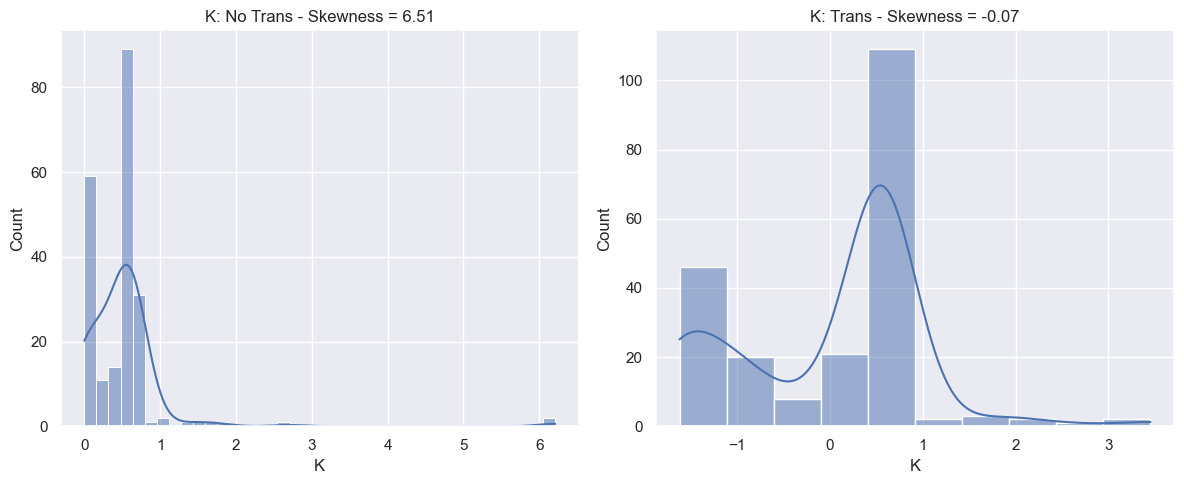

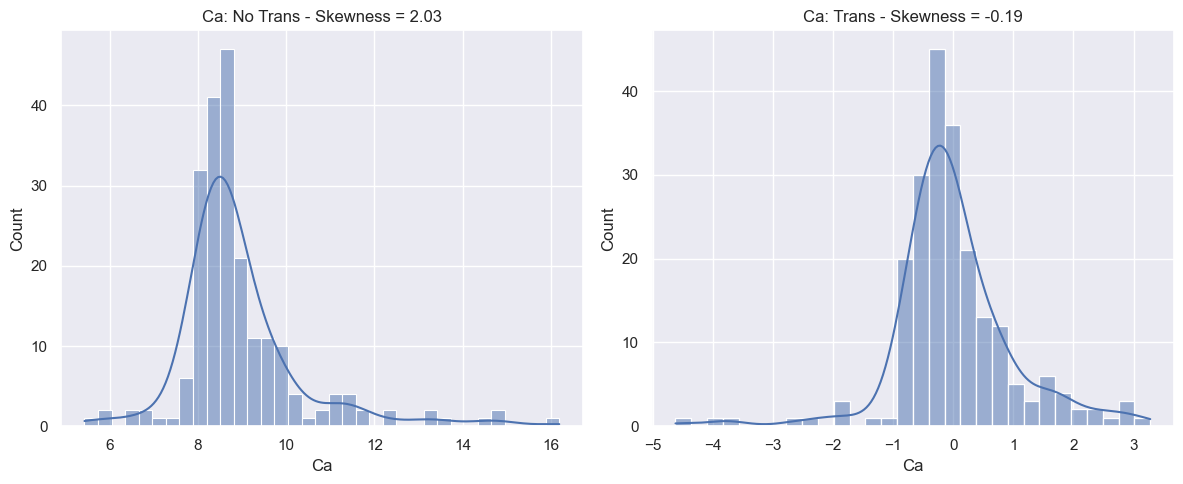

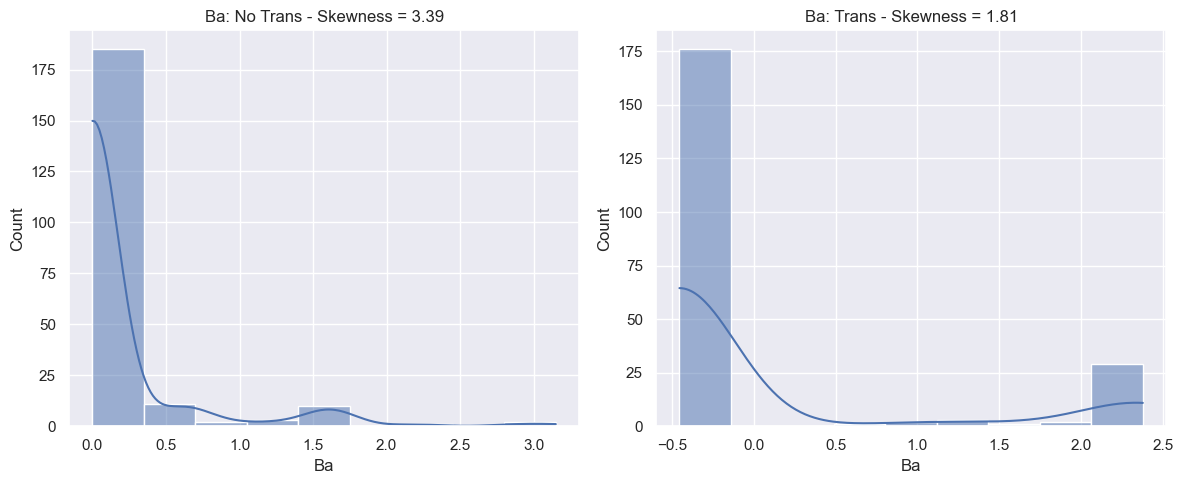

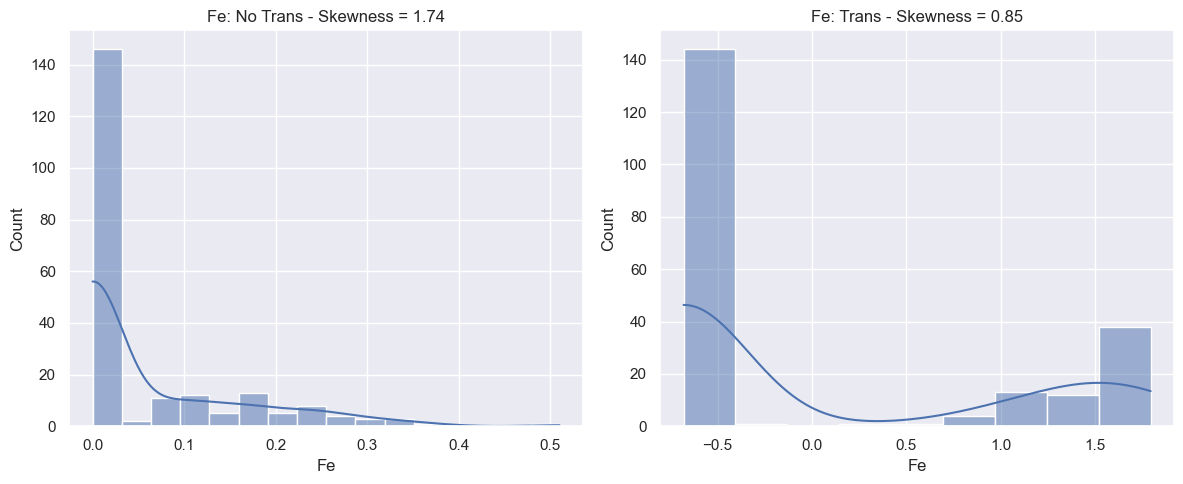

In [43]:
for col in glass_ws.columns[:-1]: # Exclude the last column 'Type' which is categorical

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original
    sns.histplot(glass_ws[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col}: No Trans - Skewness = {skew(glass_ws[col], bias=True):.2f}")
    
    # Transformed - Note that not all columns are transformed.
    sns.histplot(glass_trans[col], kde=True, ax=axes[1])
    axes[1].set_title(f"{col}: Trans - Skewness = {skew(glass_trans[col], bias=True):.2f}")
    
    plt.tight_layout()
    plt.show()

### E: 3.2
#### A. Investigate the frequency distributions for the categorical predictors. Are any of the distributions degenerate in the ways discussed earlier in this chapter?

In [44]:
nzv = near_zero_var(soybean) # Using this to determine degenerate columns
print(nzv, "\n")

# Determine value counts and unique entries of leaf.mild
counts = soybean["leaf.mild"].value_counts() # This shows that category '0' dominates the distribution in the case of leaf.mild.
unique = soybean["leaf.mild"].unique()
print(counts, "\n")
print(unique)

['leaf.mild', 'mycelium', 'sclerotia'] 

leaf.mild
0    535
1     20
2     20
Name: count, dtype: int64 

['0', NaN, '1', '2']
Categories (3, object): ['0', '1', '2']


#### B. Roughly 18 % of the data are missing. Are there particular predictors that are more likely to be missing? Is the pattern of missing data related to the classes?

In [45]:
soybean.head()  # Quick peek at the data

Class date plant.stand precip temp hail crop.hist area.dam  \
0  diaporthe-stem-canker    6           0      2    1    0         1        1   
1  diaporthe-stem-canker    4           0      2    1    0         2        0   
2  diaporthe-stem-canker    3           0      2    1    0         1        0   
3  diaporthe-stem-canker    3           0      2    1    0         1        0   
4  diaporthe-stem-canker    6           0      2    1    0         2        0   

  sever seed.tmt  ... int.discolor sclerotia fruit.pods fruit.spots seed  \
0     1        0  ...            0         0          0           4    0   
1     2        1  ...            0         0          0           4    0   
2     2        1  ...            0         0          0           4    0   
3     2        0  ...            0         0          0           4    0   
4     1        0  ...            0         0          0           4    0   

  mold.growth seed.discolor seed.size shriveling roots  
0           0             0         0          0     0  
1           0             0         0          0     0  
2           0             0         0          0     0  
3           0             0         0          0     0  
4           0             0         0          0     0  

[5 rows x 36 columns]

In [46]:
# Check transform suitability (using this to get number of NaNs - can also be seen from .info())
summary_df, boxcox_cols, yeojohnson_cols = check_transform_suitability(soybean, save_csv=True)
summary_df.head()  # Preview the summary DataFrame. Check saved csv for full picture.

Summary saved to transform_suitability.csv


Column Data Type Skewness  Apply Transformation  Box-Cox Applicable  \
0        Class  category     None                 False               False   
1         date  category     None                 False               False   
2  plant.stand  category     None                 False               False   
3       precip  category     None                 False               False   
4         temp  category     None                 False               False   

   Yeo-Johnson Applicable  NaN Count  NaN %  
0                   False          0  0.00%  
1                   False          1  0.15%  
2                   False         36  5.27%  
3                   False         38  5.56%  
4                   False         30  4.39%

In [47]:
## Check if missing data is related to class
# This will create a new column 'has_nans_in_sample' that indicates whether a sample has any NaN values in its features.
soybean['has_nans_in_sample'] = soybean.drop(columns='Class').isnull().any(axis=1)

# Create a crosstab to see the relationship between Class and has_nans_in_sample
pd.crosstab(soybean['Class'], soybean['has_nans_in_sample'])
# This clearly demonstrates that missing data is related to class.

has_nans_in_sample           False  True 
Class                                    
2-4-d-injury                     0     16
alternarialeaf-spot             91      0
anthracnose                     44      0
bacterial-blight                20      0
bacterial-pustule               20      0
brown-spot                      92      0
brown-stem-rot                  44      0
charcoal-rot                    20      0
cyst-nematode                    0     14
diaporthe-pod-&-stem-blight      0     15
diaporthe-stem-canker           20      0
downy-mildew                    20      0
frog-eye-leaf-spot              91      0
herbicide-injury                 0      8
phyllosticta-leaf-spot          20      0
phytophthora-rot                20     68
powdery-mildew                  20      0
purple-seed-stain               20      0
rhizoctonia-root-rot            20      0

#### C. Develop a strategy for handling missing data, either by eliminating predictors or imputation.

In [48]:
# Encode categories to numbers - Technically introduces bias, but that is acceptable for imputation.
encoder = OrdinalEncoder()
soybean_encoded = pd.DataFrame(
    encoder.fit_transform(soybean),
    columns=soybean.columns
)

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=3)
soybean_imputed_encoded = pd.DataFrame(
    imputer.fit_transform(soybean_encoded),
    columns=soybean.columns
)

# Decode numbers back to categories
soybean_imputed = pd.DataFrame(
    encoder.inverse_transform(soybean_imputed_encoded),
    columns=soybean.columns
)

# print("Original with missing values:\n", soybean)
# print("\nImputed DataFrame:\n", soybean_imputed)


### E: 3.3

#### A. Start R and use these commands to load the data

In [49]:
# See file access_data.md for how to export data from R to python

#### B. Do any of the individual predictors have degenerate distributions?

In [50]:
bloodbrain.head()

logBBB       tpsa  nbasic  negative    vsa_hyd  a_aro   weight  peoe_vsa.0  \
0    1.08  12.030000       1         0  167.06700      0  156.293    76.94749   
1   -0.40  49.330002       0         0   92.64243      6  151.165    38.24339   
2    0.22  50.529999       1         0  295.16700     15  366.485    58.05473   
3    0.14  37.389999       0         0  319.11220     15  382.552    62.23933   
4    0.69  37.389999       1         0  299.65800     12  326.464    74.80064   

   peoe_vsa.1  peoe_vsa.2  ...   scaa3  ctdh  ctaa    mchg    achg    rdta  \
0    43.44619     0.00000  ... -0.0093     1     1  0.9241  0.9241  1.0000   
1    25.52006     0.00000  ... -0.0754     2     2  1.2685  1.0420  1.0000   
2   124.74020    21.65084  ... -0.0303     1     4  1.2562  1.2562  0.2500   
3   124.74020    13.19232  ... -0.0240     1     3  1.1962  1.1962  0.3333   
4   118.04060    33.00190  ... -0.0255     1     3  1.2934  1.2934  0.3333   

       n_sp2    n_sp3      o_sp2      o_sp3  
0   0.000000   6.0255   0.000000   0.000000  
1   0.000000   6.5681  32.010201  33.613499  
2  26.973301  10.8567   0.000000  27.545099  
3  21.706499  11.0017   0.000000  15.131600  
4  24.206100  10.8109   0.000000  15.133300  

[5 rows x 135 columns]

In [51]:
# Use check_transform_suitability to get an overview of the data (see csv)
summary_df, boxcox_cols, yeojohnson_cols = check_transform_suitability(bloodbrain, save_csv=True)

Summary saved to transform_suitability.csv


In [52]:
# Use near zero variance function to find degenerate columns
nzv = near_zero_var(bloodbrain)
print("Near-zero variance columns:", nzv)

Near-zero variance columns: ['negative', 'peoe_vsa.2.1', 'peoe_vsa.3.1', 'a_acid', 'vsa_acid', 'frac.anion7.', 'alert']


In [53]:
# Print nzv columns
print(bloodbrain[nzv].head(20))

    negative  peoe_vsa.2.1  peoe_vsa.3.1  a_acid  vsa_acid  frac.anion7.  \
0          0       0.00000      0.000000       0       0.0         0.000   
1          0       0.00000      0.000000       0       0.0         0.001   
2          0       0.00000      0.000000       0       0.0         0.000   
3          0       0.00000      0.000000       0       0.0         0.000   
4          0       0.00000      0.000000       0       0.0         0.000   
5          0       0.00000      0.000000       0       0.0         0.000   
6          0       0.00000      0.000000       0       0.0         0.001   
7          0       0.00000      0.000000       0       0.0         0.000   
8          0      19.76062      0.000000       0       0.0         0.000   
9          0       0.00000      0.000000       0       0.0         0.000   
10         0      10.88526      0.136891       0       0.0         0.000   
11         0       0.00000      0.000000       0       0.0         0.000   
12         0

#### C. Generally speaking, are there strong relationships between the predictor data? If so, how could correlations in the predictor set be reduced? Does this have a dramatic effect on the number of predictors available for modeling?

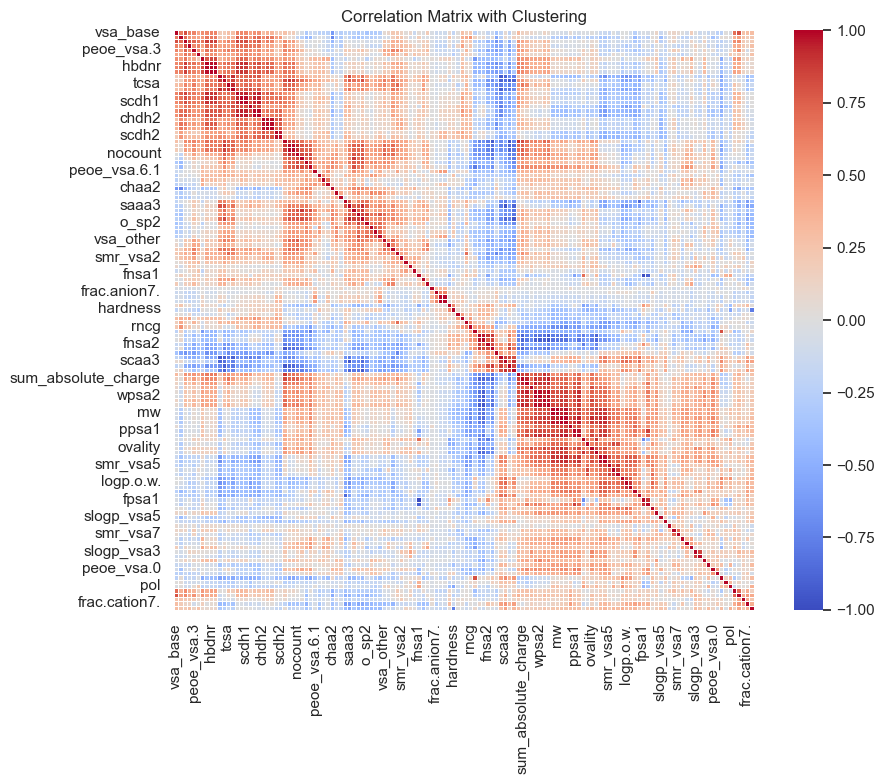

In [54]:
# Use defined function to plot correlations between predictors - exclude 1st column (outcome column, logBBB)
corr_mat = plot_corr(bloodbrain.iloc[:, 1:])

In [60]:
# Use find_correlation to determine columns for deletion
cols_to_delete = find_correlation(bloodbrain.iloc[:, 1:])

print(f"Number of columns to delete: {len(cols_to_delete)}")
print(f"Total number of feature-columns for comparison {len(bloodbrain.columns)-1}") # First column is target column

Number of columns to delete: 66
Total number of feature-columns for comparison 134
